# Data Description

- ENG: 56 electrode organized 14x4 sampled at 30kHz. Abive elbow
    - 2 implanted in the median 
    - 2 in the ulnar nerve
- sEMG: 4 grids on the residual forearm sampled at 2kHz
    - 2 on flexors: digit flexor extrinsic muscle?
    - 2 on extensors: digit flexor extrinsic muscle?


- Mulitple days
    - Day 16
    - Day 17
    - Day 20
    - Day 23: 2 sessions: one in the morning and one in the afternoon

- Reps:
    - 5 grips: each repeated 10 times
    - Trial is 2 sec (1sec flex, 1 sec ext) - 3 sec rest


- Revisit data preprocessing
    - Do we see particular peaks with flexions/ extensions?
        - Consider each part separately?
    - Where are they coming from? from which electrode? Create a map of electrode/peak amplitude distribution

    - Repeat the same for first day and last day 


In [1]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from srcs.engdataset import ENGDataset, Nerve
from utils.evaluate_model import  compute_metric, get_perf_results

import utils.preprocessing as pre
import utils.classify as classify
import utils.plot as uplot

from constants import *

from collections import Counter
import logging
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from typing import Dict, List


plt.rcParams.update({"figure.dpi": 150})
plt.rcParams['axes.axisbelow'] = True
logging.getLogger().setLevel(logging.INFO)
matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })

logging.getLogger().setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2



# 1. Load ENG data

- raw_ENG: REC, Time, Trigger

In [2]:
# load raw ENG for the following parameters
day = 16                   # day of recording
session = '01'             # session of recording

preproc_plots = False      # whether to plot figures during preprocessing
filter_signal = False      # whether to filter all channels or reload a saved file with filtered data
save_figs = True

In [3]:
# create directory for figures
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)
if not os.path.exists(CLF_FIG):
    os.makedirs(CLF_FIG)
if not os.path.exists(FILTERED_DIR):
    os.makedirs(FILTERED_DIR)

CLF_FIG = os.path.join(FIG_DIR, 'clf')
if not os.path.exists(CLF_FIG):
    os.makedirs(CLF_FIG)

In [4]:
eng_dataset = ENGDataset(day= day, session=session, load_raw_data = True, save_figs=save_figs)
pipeline = {'bp_order': 3, 'bp_cutoff_freq': np.array([300, 2000]), 'notch_bandwidth': 0.5, 'notch_reject': 50}
eng_dataset.filt_pipeline = pipeline

INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG.mat
INFO:root:Loading data from /Users/farahbaracat/Library/CloudStorage/OneDrive-UniversitätZürichUZH/ENG upper dataset/Data_TIME_Marina/day16/AM_prese_1601_raw_ENG_ok.mat
INFO:root:Creating dictionary of reps count per task: {0: 10, 1: 10, 2: 10, 3: 7, 4: 10}
INFO:root:Time column of post_data(7157879,) 
Rec column of post_data(56, 7157879)


In [5]:
def show_matfile_vars(data):
    for key in data.keys():
        if isinstance(data[key], np.ndarray):
            print(f"{key}: {data[key].dtype} {data[key].shape} ")
        if isinstance(data[key], list):
            print(f"{key}: list {len(data[key])}")
    print("\n")
show_matfile_vars(eng_dataset.raw_data)
show_matfile_vars(eng_dataset.post_data)

REC: float64 (56, 7607880) 
Time: float64 (7607880,) 
Trigger: float64 (49,) 


REC: float64 (56, 7157879) 
SEGM_tot: list 5
Trigger: float64 (47,) 
Time: float64 (7157879,) 




### Checking on the original file 

check on time difference between triggers:
[5.0006     4.99983333 4.99973333 4.99976667 5.00023333 5.00023333
 4.99966667 4.9998     5.00043333 4.99906667 5.0005     5.0001
 4.9997     4.99976667 4.9998     4.9998     4.9995     4.99993333
 5.00033333 5.00066667 4.9991     4.99973333 5.00046667 4.99896667
 5.00063333 5.00026667 4.99983333 4.99906667 5.00053333 4.99973333
 4.99983333 4.9998     5.0003     5.00056667 9.99936667 4.9998
 4.999      5.0007     4.99946667 5.00053333 4.99926667 4.99976667
 5.00053333 4.9991     5.00056667 4.9996     5.0006     4.99906667]

Trial with a trigger longer than 5 seconds:
[34]


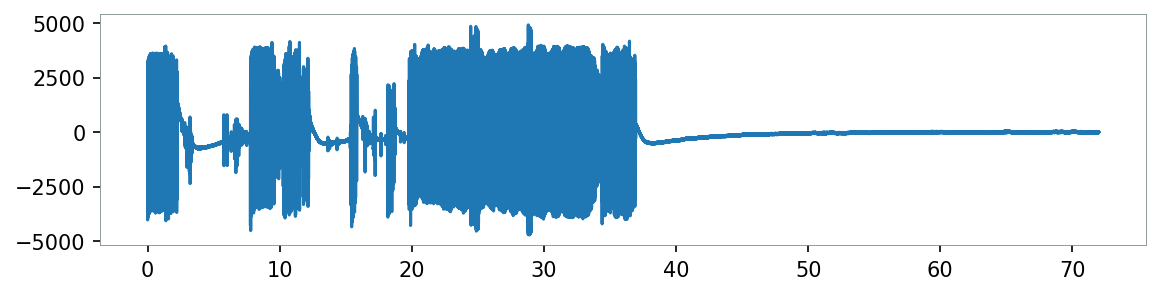

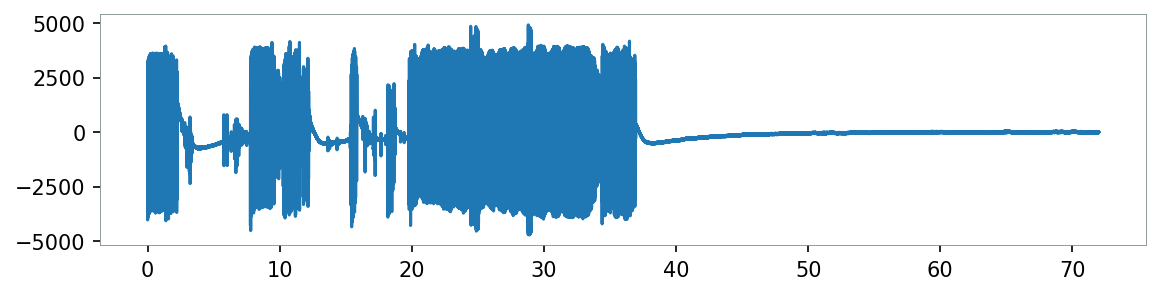

In [6]:
print(f"check on time difference between triggers:\n{np.diff(eng_dataset.raw_data[TRIG_VAR])}")
print(f"\nTrial with a trigger longer than 5 seconds:\n{np.where(np.diff(eng_dataset.raw_data[TRIG_VAR]) > 5.1)[0]}")

# Plot and label segments from raw_data
# It seems that channel 1 is dead during some parts of the recording
ch = 1
t_dead = 72  # in sec
plt.figure(figsize=(9, 2))
plt.plot(eng_dataset.raw_data[TIME_VAR][:t_dead * eng_dataset.fs], 
         eng_dataset.raw_data[ENG_RAW_VAR][ch, :t_dead * eng_dataset.fs])

# plot the same channel with post_data
plt.figure(figsize=(9, 2))
plt.plot(eng_dataset.post_data[TIME_VAR][:t_dead * eng_dataset.fs], 
         eng_dataset.post_data[ENG_RAW_VAR][ch, :t_dead * eng_dataset.fs])
# plt.show()

In [7]:
# CHECKTHIS: do I need to even load raw_data
print(eng_dataset.raw_data[TRIG_VAR])

print("\n", eng_dataset.post_data[TRIG_VAR])

eng_dataset.post_data['Time'].shape, eng_dataset.post_data[ENG_RAW_VAR].shape


print(np.diff(eng_dataset.raw_data[TRIG_VAR]),"\n")
print(np.diff(eng_dataset.post_data[TRIG_VAR]))

[  3.92006667   8.92066667  13.9205      18.92023333  23.92
  28.92023333  33.92046667  38.92013333  43.91993333  48.92036667
  53.91943333  58.91993333  63.92003333  68.91973333  73.9195
  78.9193      83.9191      88.9186      93.91853333  98.91886667
 103.91953333 108.91863333 113.91836667 118.91883333 123.9178
 128.91843333 133.9187     138.91853333 143.9176     148.91813333
 153.91786667 158.9177     163.9175     168.9178     173.91836667
 183.91773333 188.91753333 193.91653333 198.91723333 203.9167
 208.91723333 213.9165     218.91626667 223.9168     228.9159
 233.91646667 238.91606667 243.91666667 248.91573333]

 [  3.92006667   8.92066667  13.9205      18.92023333  23.92
  28.92023333  33.92046667  38.92013333  43.91993333  48.92036667
  53.91943333  58.91993333  63.92003333  68.91973333  73.9195
  78.9193      83.9191      88.9186      93.91853333  98.91886667
 103.91953333 108.91863333 113.91836667 118.91883333 123.9178
 128.91843333 133.9187     138.91853333 143.9176     148

In [8]:
eng_dataset.post_data[SEG_VAR]

[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([1., 2., 3., 4., 5., 6., 7.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])]

In [9]:
eng_dataset.post_data[TRIG_VAR]
#check if triggers are included in the raw data
for t in eng_dataset.post_data[TRIG_VAR]:
    if t in eng_dataset.raw_data[TRIG_VAR]:
        print(t)


3.9200666666666666
8.920666666666667
13.9205
18.920233333333332
23.92
28.920233333333332
33.92046666666667
38.92013333333333
43.91993333333333
48.920366666666666
53.91943333333333
58.91993333333333
63.920033333333336
68.91973333333334
73.9195
78.9193
83.9191
88.9186
93.91853333333333
98.91886666666667
103.91953333333333
108.91863333333333
113.91836666666667
118.91883333333334
123.9178
128.91843333333333
133.9187
138.91853333333333
143.9176
148.91813333333334
153.91786666666667
158.9177
163.9175


In [10]:
mask = np.diff(eng_dataset.post_data['Time'],prepend=0)> 1/eng_dataset.fs
eng_dataset.post_data['Time']



array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       2.38595867e+02, 2.38595900e+02, 2.38595933e+02])

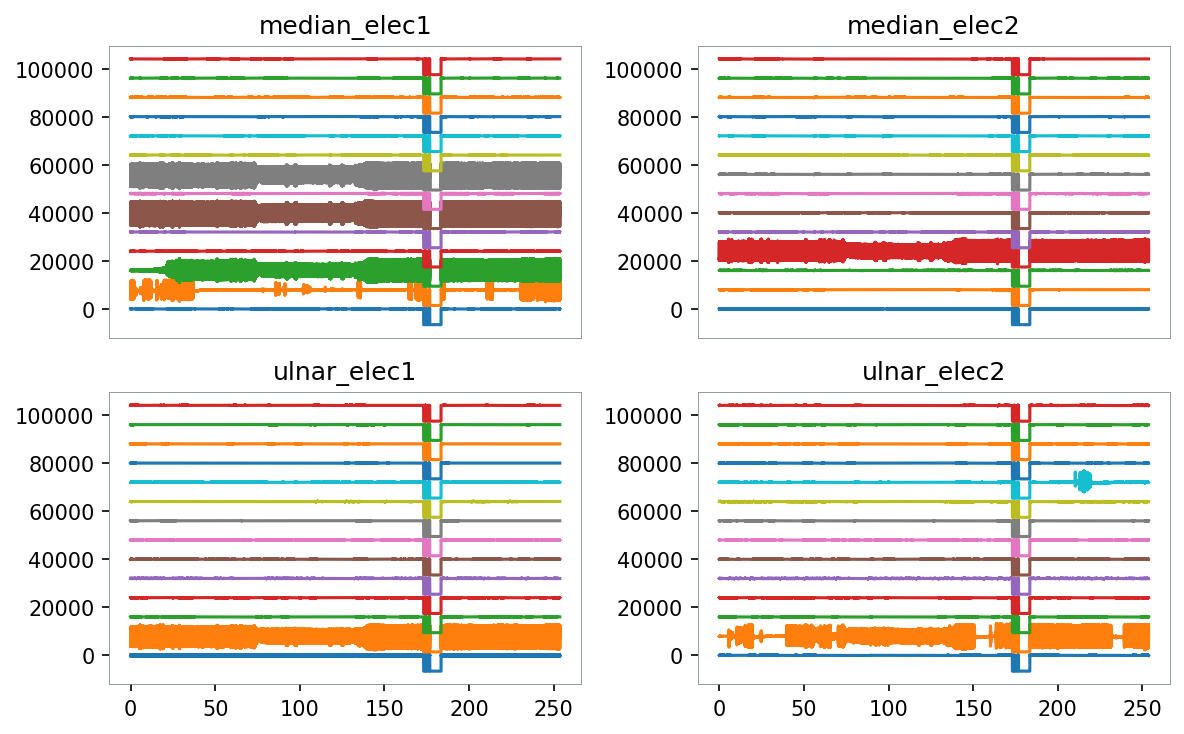

In [11]:
# Grid plot all channels for each nerve
fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(eng_dataset.n_nerves, eng_dataset.n_elec_per_nerve)
for row in range(eng_dataset.n_nerves):
    for task_id in range(eng_dataset.n_elec_per_nerve):
        nerve_elec = list(Nerve)[eng_dataset.n_nerves*row + task_id]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]
        ax = fig.add_subplot(gs[row, task_id])

        for shift, ch in enumerate(ch_group):
            ax.plot(eng_dataset.raw_data[TIME_VAR], eng_dataset.raw_data[ENG_RAW_VAR][ch,:].T + 8000*shift)
        ax.set_title(f"{nerve_elec.value}", fontsize=12)
        if row ==0 :
            ax.set_xticks([])
fig.tight_layout()


#### Manually identify corrupt chs and dead times in recording

In [12]:
#TODO: automatically identify the bad channels and range to be used for the remaining days as well
def detect_bad_channels(eng_dataset):
    # Get first 170 seconds of recording and check on data range. I know a-priori that the first 170 seconds are good
    baseline_dur = 50 # in seconds
    time_sample = baseline_dur * ENG_FS

    corrupt_chs = []
    for ch in range(N_CHANNELS):
        ch_min = np.min(eng_dataset.raw_data[ENG_RAW_VAR][ch, :time_sample])
        ch_max = np.max(eng_dataset.post_data[ENG_RAW_VAR][ch, :time_sample])

    # locate corrupt channels
        if ch_min < -1000:
        # print(f"corrupt channel: {ch}\n")
            corrupt_chs.append(ch)

    print(f"corrupt channels: {corrupt_chs}")
    return corrupt_chs


def identify_bad_range(ch, eng_dataset, data_type='raw'):
    if data_type == 'raw':
        eng_data = eng_dataset.raw_data
    if data_type == 'post':
        eng_data = eng_dataset.post_data
    
    dur = 170 # in seconds
    time_sample = dur * eng_dataset.fs
    ch_min = np.min(eng_data[ENG_RAW_VAR][ch, :time_sample])
    ch_max = np.max(eng_data[ENG_RAW_VAR][ch, :time_sample])

    # locate corrupt range in recording
    mask = eng_data[ENG_RAW_VAR][ch, :] < ch_min - 10  # 10 uV below min to be certain
    bad_range = (eng_data[TIME_VAR][mask][0], eng_data[TIME_VAR][mask][-1])
    print(f"CH # {ch}: {ch_min} to {ch_max} corrupt range: {bad_range}")
    return ch_max, ch_min, bad_range



In [13]:
bad_chs = detect_bad_channels(eng_dataset)
good_chs = [ch for ch in range(eng_dataset.n_channels) if ch not in bad_chs]

print(f"Identified bad channels (based on a-priori knowledge):\n{bad_chs}")

corrupt channels: [1, 2, 5, 7, 17, 29, 43]
Identified bad channels (based on a-priori knowledge):
[1, 2, 5, 7, 17, 29, 43]


In [ ]:
# Plot corrupt channels in a grid
if preproc_plots:
    fig = plt.figure(figsize=(9, 4))
    gs = gridspec.GridSpec(5, 2)

    plot_dur = 10   # in seconds
    plot_samp = int(plot_dur * eng_dataset.fs)  

    for row, ch in enumerate(bad_chs + good_chs[:3]): # select some good channels as well for comparison
        ax = fig.add_subplot(gs[row])
        c = COLOR_DICT['midnight_blue']
        label = 'bad'
        if ch in good_chs:
            c =COLOR_DICT['green_sea']
            label = 'good'
        ax.plot(eng_dataset.raw_data[TIME_VAR][:plot_samp], 
                eng_dataset.raw_data[ENG_RAW_VAR][ch, :plot_samp], 
                color = c, label=label)
        plt.legend()
        plt.box(False)
        ax.set_title(f"ch {ch}")
        plt.tight_layout()

    # add x and y labels common to all subplots
    fig.text(0.5, 0.01, 'time (s)', ha='center', va='center', fontsize=8)
    fig.text(0.01, 0.5, 'amplitude (uV)', ha='center', va='center', rotation='vertical', fontsize=8)

    # save figure
    if eng_dataset.save_figs:
        fig.savefig(os.path.join(FIG_DIR, f'day{day}{session}bad_chs.png'), dpi=300, bbox_inches='tight')


In [ ]:
_,ch_min, bad_range = identify_bad_range(0, eng_dataset)

In [ ]:
fig = plt.figure(figsize=(9, 2))
gs = gridspec.GridSpec(1, 4)

for row, ch in enumerate(good_chs[:4]):
    _,ch_min, bad_range = identify_bad_range(ch, eng_dataset)

    if row < 7:

        samp_mask = np.where(eng_dataset.raw_data[ENG_RAW_VAR][ch, :] < ch_min)[0] - 30000
        first_samp = samp_mask[0] - 30000 # 1 second before
        last_samp = samp_mask[-1] + 2* 30000 # 2 seconds after
        ax = fig.add_subplot(gs[row])
        ax.plot(eng_dataset.raw_data[TIME_VAR][first_samp: last_samp],
                eng_dataset.raw_data[ENG_RAW_VAR][ch, first_samp:last_samp])
        plt.box(False)
        ax.set_title(f"ch {ch}")
        plt.tight_layout()

#add x and y labels common to all subplots
fig.text(0.5, 0.01, 'time (s)', ha='center', va='center', fontsize=8)
fig.text(0.01, 0.5, 'amplitude (uV)', ha='center', va='center', rotation='vertical', fontsize=8)

# save figure
# fig.savefig(os.path.join(FIG_DIR, f'day{day}{session}bad_rec_range.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
if preproc_plots:
    # cut out bad range
    # ch_max, ch_min, bad_range = identify_bad_range(0, eng_raw)
    # mask = (eng_raw[TIME_VAR] < bad_range[0]) | (eng_raw[TIME_VAR] > bad_range[1])
    # eng_raw[TIME_VAR] = eng_raw[TIME_VAR][mask]
    # eng_raw[ENG_RAW_VAR] = eng_raw[ENG_RAW_VAR][:, mask]

    # check plot
    plt.figure(figsize=(9, 2))
    plt.plot(eng_dataset.raw_data[TIME_VAR], eng_dataset.raw_data[ENG_RAW_VAR][0, :])


#### Extracting good trials triggers from original file

In [ ]:
# cut trigger as well
trig_mask = (eng_dataset.raw_data[TRIG_VAR] < bad_range[0]) | (eng_dataset.raw_data[TRIG_VAR] > bad_range[1])

# do it on the dataframe
# trig_df_raw_cut = trig_df_raw[(trig_df_raw[TRIG_VAR] < bad_range[0]) | (trig_df_raw[TRIG_VAR] > bad_range[1])]


In [ ]:
# trig_df_raw_cut

In [ ]:
# # check plot
# fig = plt.figure(figsize=(10, 2))
# plt.plot(eng_raw[TIME_VAR], eng_raw[ENG_RAW_VAR][0, :])

# for rep in trig_df_raw_cut[TRIG_VAR]:
#     plt.axvline(x=rep, color='r', linestyle='--')

# plt.show()

In [ ]:
# time_cut = eng_raw[TIME_VAR][:eng_post[ENG_RAW_VAR].shape[1]]
# time_cut, time_cut[-1]
# eng_post[TIME_VAR] = time_cut
# print(eng_post[TIME_VAR].shape, eng_post[ENG_RAW_VAR].shape)

### Checking on the _ok file data (manually labelled)

/Users/farahbaracat/Documents/PhD Research/Code/class_eng_snn/utils/plot/recording.py:44: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/snn_iemg/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


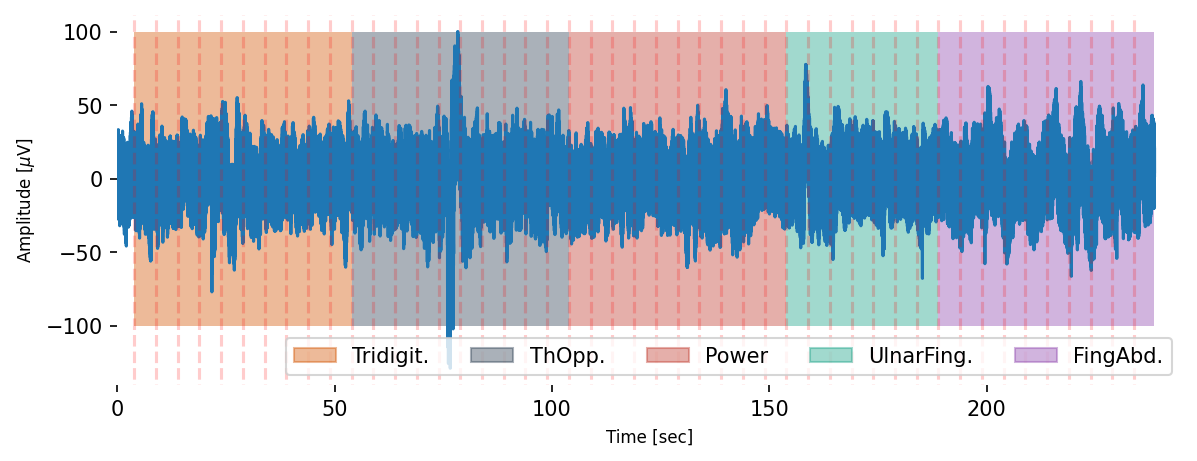

/Users/farahbaracat/Documents/PhD Research/Code/class_eng_snn/utils/plot/recording.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(FIG_DIR, f"{base_filename}_{fill}_eng_cut_annotate_reps.png"),


In [14]:
#MANPLOT: Raw ENG for a single channel with start and end of each trial marked
title = f"Raw ENG data, day {day}, session {session} [manually cut and relabelled]" #[manualy cut bad range, using _ok.mat file]"
plot_ch = 0
uplot.plot_ch_annotate_trials(eng_dataset, plot_ch, y_range=[-100,100], title='', data_type='post')


In [ ]:
fig = plt.figure(figsize=(5,3))
start_time = 5   #in sec
end_time = 5.1    #in sec
ch=10
s_samp = int(start_time*eng_dataset.fs)
e_samp = int(end_time*eng_dataset.fs)
plt.plot(eng_dataset.post_data_df[TIME_VAR][s_samp:e_samp],
         eng_dataset.post_data_df[ch][s_samp:e_samp])


The observed oscillation is due to 50Hz interference. (5 cycle in 100 ms = 50 Hz)

# 2. Filter the raw data (without downsampling)

- Steps:
    1. Notch filters removal of 50 Hz power line + multiples? Check on frequency response
    2. BPF: what range to use: [500 Hz - ]
        - Compute SNR before and after each filtering step
- Extract power of the signal in each trial, gesture, electrode?

- Typical Fitlering Steps:
    1. notch filters
    2. anti-aliasing filter: digital low-pass i.e removal of very high-frequencies (this limits the bandwidth to f_lp)
    3. decimate by a factor of M: new sampling rate should be below Nyquist rate( 2*fcutoff): should be greater than 2*f_lp
    4. BP signal in the range where information resides

**Option 1: Do not decimate**
- Notch
- BPF in range higher than EMG

**Option 2: Decimate**
- Notch
- LPF: cutoff 4KHz
- Decimate by factor of 3
- BPF [500 - 10KHz]
 

## Apply filter on all channels

In [34]:
if filter_signal: # filter all channels and plot the bandpassed version
    notch_filt_data, bp_filt_data = pre.apply_filter_pipeline(eng_dataset)

    if preproc_plots:
    # plot single ch fft after filtering
        fig = plt.figure(figsize=(8, 4))
        gs = gridspec.GridSpec(nrows=3, ncols=1)
        sel_ch = 0
        xlim = [0,  pipeline['bp_cutoff_freq'][-1]]  # in Hz

        xf_raw, yf_raw = pre.get_fft(np.array(eng_dataset.post_data_df[sel_ch]), ENG_FS)

        xf_bp, yf_bp = pre.get_fft(bp_filt_data[:, sel_ch], ENG_FS)
        xf_not, yf_not = pre.get_fft(notch_filt_data[:, sel_ch], ENG_FS)

        ax = fig.add_subplot(gs[0])
        ax.plot(xf_raw, np.sqrt(np.abs(yf_raw)), label='raw', color=COLOR_DICT['midnight_blue'])
        ax.set(frame_on=False)
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.title(f"Signal ch:{sel_ch} after Notch filters + BP: {pipeline['bp_cutoff_freq']}", fontsize=8)

        ax2 = fig.add_subplot(gs[1])
        ax2.plot(xf_not, np.sqrt(np.abs(yf_not)), label='Notch', color=COLOR_DICT['pumpkin'])
        ax2.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)

        # plt.xticks(ticks=np.arange(-0,1000,50))
        plt.ylabel('amplitude [uV]')

        ax1 = fig.add_subplot(gs[2])
        ax1.plot(xf_bp, np.sqrt(np.abs(yf_bp)), label='BPF', color=COLOR_DICT['midnight_blue'])
        ax1.set(frame_on=False)
        plt.legend()
        plt.xlim(xlim)
        plt.ylabel('amplitude [uV]')
        plt.xlabel('freq [Hz]')
        plt.show()

        fig.savefig(f"figures/fft_bp_{pipeline['bp_cutoff_freq'][0]}_"
                    f"{pipeline['bp_cutoff_freq'][1]}.png")

## Preload filtered data

In [35]:
# save filtered data to pickle or load from pickle a presaved filtered data
filt_filename = f"day{eng_dataset.day}_eng_filt_{eng_dataset.filt_pipeline['bp_cutoff_freq'][0]}_{eng_dataset.filt_pipeline['bp_cutoff_freq'][1]}.pkl"

if filter_signal:
    # organize filtered data in dataframe
    filt_df = pd.DataFrame(bp_filt_data)
    filt_df[TIME_VAR] = eng_dataset.post_data_df[TIME_VAR]
    filt_df.to_pickle(os.path.join(FILTERED_DIR, filt_filename))
else:
    logging.info(f"Loading filtered data from {filt_filename}")
    filt_df = pd.read_pickle(os.path.join(FILTERED_DIR, filt_filename))
eng_dataset.filt_df = filt_df


INFO:root:Loading filtered data from day16_eng_filt_300_2000.pkl


In [9]:
bad_channels, bad_channels_std = pre.detect_bad_channels(eng_dataset, std_threshold=5)
print(bad_channels, bad_channels_std)

INFO:root:Nerve.MEDIAN_E1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Channels median of stds: 2.436720069396273

INFO:root:Nerve.MEDIAN_E2: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Channels median of stds: 2.464861673937028

INFO:root:Nerve.ULNAR_E1: [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Channels median of stds: 2.6221494489717427

INFO:root:Nerve.ULNAR_E2: [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
Channels median of stds: 2.89904068199269



[1, 52] [27.767810331490004, 56.19235287002034]


In [ ]:
# Re-check on the effect of the power line interference
#TODO: check on units and scaling (cf. Spike interface): 
# https://spikeinterface.readthedocs.io/en/latest/modules_gallery/extractors/plot_2_working_with_unscaled_traces.html#sphx-glr-modules-gallery-extractors-plot-2-working-with-unscaled-traces-py

fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)

start_time = 5   #in sec
end_time = 5.2    #in sec
ch=10
s_samp = int(start_time*eng_dataset.fs)
e_samp = int(end_time*eng_dataset.fs)

ax = fig.add_subplot(gs[0])
ax.plot(eng_dataset.post_data_df[TIME_VAR][s_samp:e_samp],
         eng_dataset.post_data_df[ch][s_samp:e_samp])

ax = fig.add_subplot(gs[1])
ax.plot(eng_dataset.filt_df[TIME_VAR][s_samp:e_samp],
         eng_dataset.filt_df[ch][s_samp:e_samp])


In [ ]:
if preproc_plots:
    # plot some channels after filtering
    fig = plt.figure(figsize=(8, 4))
    gs = gridspec.GridSpec(nrows=5, ncols=2)

    plot_chs = bad_chs + good_chs[:10-len(bad_chs)]
    plot_samp = 30  # in seconds

    for row, sel_ch in enumerate(plot_chs):
        c = COLOR_DICT['midnight_blue']
        label = 'bad'
        if sel_ch in good_chs:
            c =COLOR_DICT['green_sea']
            label = 'good'

        # slice the first plot_dur seconds
        plot_filt_df = eng_dataset.filt_df[filt_df[TIME_VAR] < plot_samp]

        ax = fig.add_subplot(gs[row])
        ax.plot(plot_filt_df[TIME_VAR], plot_filt_df[sel_ch], label=f'filt_{label}', color=c)
        plt.legend()
        ax.set(frame_on=False)
        plt.title(f"Ch {sel_ch}", fontsize=8)
        plt.tight_layout()

    #add x and y labels common to all subplots
    fig.text(0.5, 0.01, 'time (s)', ha='center', va='center', fontsize=8)
    fig.text(0.01, 0.5, 'amplitude (uV)', ha='center', va='center', rotation='vertical', fontsize=8)




In [ ]:
title = f"FILT ENG data, day {day}, session {session} [manualy cut bad range, using _ok.mat file]"
ch = 0
uplot.plot_ch_annotate_trials(eng_dataset, ch, y_range=[-10,10], title=title, data_type='filt')


In [25]:
Counter(eng_dataset.trig_df['task_id'])
eng_dataset.trig_df

,Trigger,task_id
0,2.783733,0
1,7.783500,0
2,12.783767,0
3,17.783133,0
4,22.783033,0
5,27.783133,0
6,32.783933,0
7,37.783133,0
8,42.783033,0
9,47.783300,0


0: 28.920233333333332 - 33.92046666666667
1: 78.9193 - 83.9191
2: 128.91843333333333 - 133.9187
3: 178.91653333333332 - 183.91723333333334
4: 213.9159 - 218.91646666666668


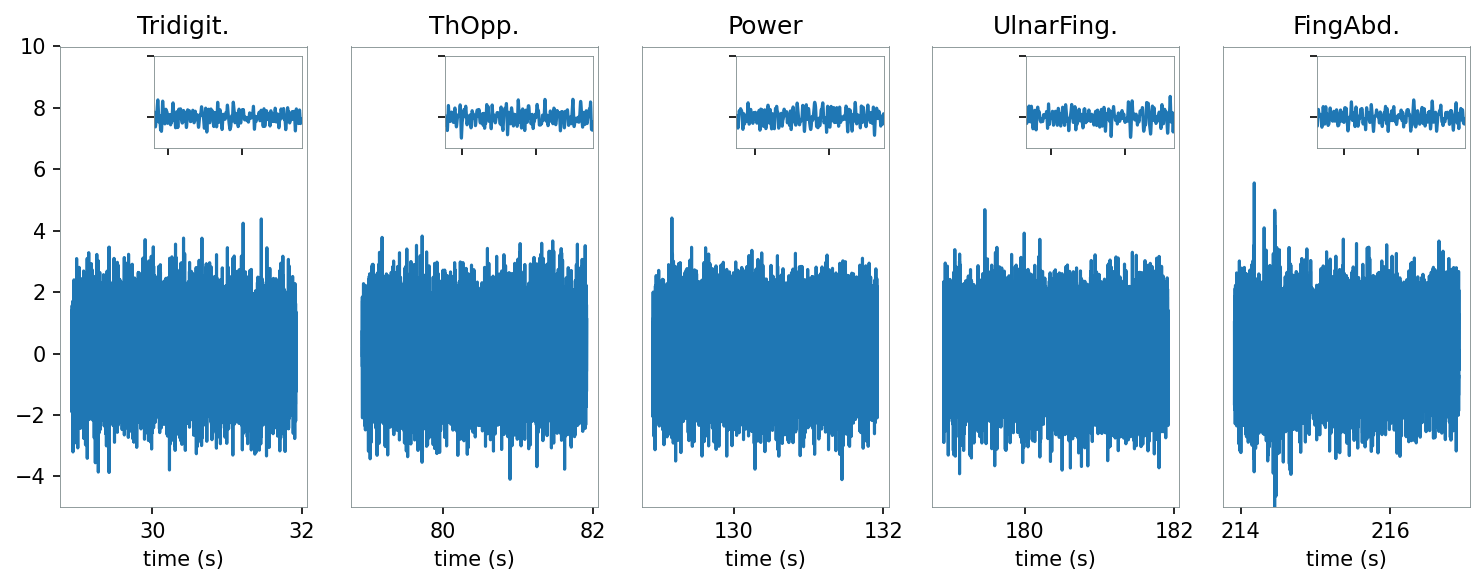

In [38]:
# Plot each task separatetely with insets?
rep_id = 5
plot_ch = 10
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, eng_dataset.n_tasks)
ylim = [-5, 10]
for task_id in range(eng_dataset.n_tasks):
    task_rep_s, task_rep_e = pre.get_trig_start_end_for_task(eng_dataset.filt_df,
                                                             eng_dataset.trig_df,
                                                             rep_id=rep_id,
                                                             task_id=task_id,
                                                             n_reps_dict=eng_dataset.task_rep_count)
    print(f"{task_id}: {task_rep_s} - {task_rep_e}")
    # exclude last 2 seconds (rest period)
    # task_rep_e -= 2  # in seconds
    task_rep_e = task_rep_s + 3
    time_mask = (eng_dataset.filt_df[TIME_VAR] >= task_rep_s) & (eng_dataset.filt_df[TIME_VAR] <= task_rep_e)
    ax = fig.add_subplot(gs[task_id])
    ax.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask])
    ax.set_title(f"{eng_dataset.task_order[task_id]}")
    ax.set_ylim(ylim)
    if task_id > 0:
        ax.set_yticks([])
    ax.set_xlabel(TIME_XLAB)
    # add insets
    inset_start = task_rep_s + 0.1
    inset_end = inset_start + 0.05
    time_mask_inset = (eng_dataset.filt_df[TIME_VAR] >= inset_start) & (
        eng_dataset.filt_df[TIME_VAR] <= inset_end)

    # subregion of the original image
    x1, x2, y1, y2 = inset_start, inset_end, ylim[0], ylim[1]

    axins = ax.inset_axes([0.38, 0.78, 0.6, 0.2],  # right-algined[0.2, 0.78, 0.8, 0.2]
                          xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

    axins.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[
               time_mask_inset], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask_inset])
fig.tight_layout()

0: 28.920233333333332 - 33.92046666666667


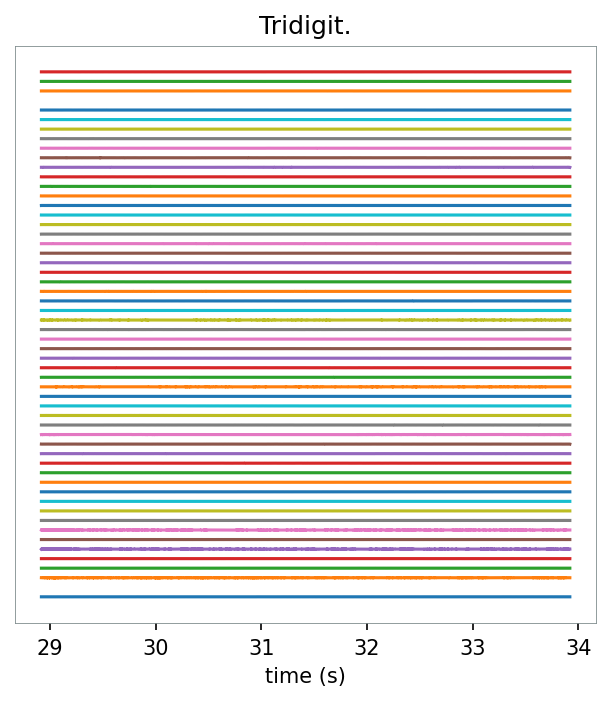

In [40]:
# plot few seconds of data for all channels single task
rep_id = 5
task_id = 0

task_rep_s, task_rep_e = pre.get_trig_start_end_for_task(eng_dataset.filt_df,
                                                            eng_dataset.trig_df,
                                                            rep_id=rep_id,
                                                            task_id=task_id,
                                                            n_reps_dict=eng_dataset.task_rep_count)
print(f"{task_id}: {task_rep_s} - {task_rep_e}")

# exclude last 2 seconds (rest period)
fig = plt.figure(figsize=(5, 5))

time_mask = (eng_dataset.filt_df[TIME_VAR] >= task_rep_s) & (eng_dataset.filt_df[TIME_VAR] <= task_rep_e)
ax = fig.add_subplot(111)

for plot_ch in range(eng_dataset.n_channels):
    if plot_ch in bad_channels:
        continue
    ax.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask] + 2000*plot_ch)
    ax.set_title(f"{eng_dataset.task_order[task_id]}")
    ax.set_xlabel(TIME_XLAB)
    ax.set_yticks([])
# ax.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask])

FingAbd. start:227.77923333333334  - 240.1241
Close:228.07923333333335 - 228.37923333333336


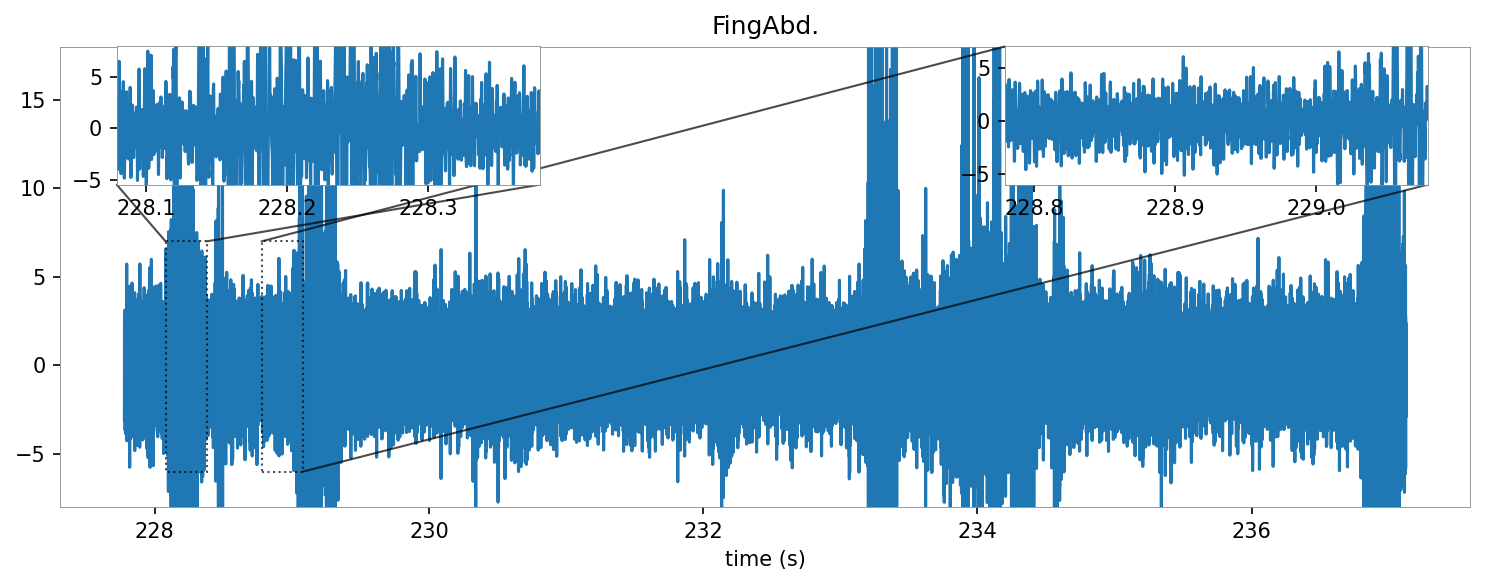

In [10]:
# Plot a single task with inset as all tasks don't add up information
# TODO: check this plot for MANPLOT
rep_id = 5
plot_ch =  30
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
ylim = [-8, 18]
# for col in range(eng_dataset.n_tasks):
task_id = 4
task_rep_s, task_rep_e = pre.get_trig_start_end_for_task(eng_dataset.filt_df,
                                            eng_dataset.trig_df, 
                                            rep_id=rep_id, 
                                            task_id=task_id,
                                            n_reps_dict=eng_dataset.task_rep_count)
print(f"{eng_dataset.task_order[task_id]} start:{task_rep_s}  - {task_rep_e}")
# exclude last 2 seconds (rest period)
task_rep_e -= 3  # in seconds
# task_rep_e = task_rep_s + 3
time_mask = (eng_dataset.filt_df[TIME_VAR]>=task_rep_s) & (eng_dataset.filt_df[TIME_VAR]<=task_rep_e)
ax = fig.add_subplot(gs[0])
ax.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask])
ax.set_title(f"{eng_dataset.task_order[task_id]}")
ax.set_ylim(ylim)
# if col >0:
#     ax.set_yticks([])
ax.set_xlabel(TIME_XLAB)
# add insets for open and close phases
inset_dur = 0.3
inset_start = task_rep_s  +0.3
inset_end = inset_start + inset_dur

print(f"Close:{inset_start} - {inset_end}")
time_mask_inset = (eng_dataset.filt_df[TIME_VAR]>=inset_start) & (eng_dataset.filt_df[TIME_VAR]<=inset_end)

x1, x2, y1, y2 = inset_start, inset_end, -5.5 , 8 #ylim[1]  # subregion of the original image

axins = ax.inset_axes([0.04, 0.7, 0.3, 0.3],  # right-algined[0.2, 0.78, 0.8, 0.2] left aligned
        xlim=(x1, x2), ylim=(y1, y2))#, xticklabels=[], yticklabels=[])
axins.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask_inset], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask_inset])
ax.indicate_inset(bounds=[inset_start,7,inset_dur, -13], inset_ax=axins, edgecolor="black", alpha=0.7, linestyle='dotted',) #inset_ax=axins, bounds=[inset_start,-5,inset_dur, 10], 
# ax.indicate_inset_zoom(axins, edgecolor="black", linestyle='dotted', alpha=0.7,
#                        xy=[inset_start, 5]) #inset_ax=axins, bounds=[inset_start,-5,inset_dur, 10], 

inset_start = task_rep_s + 1 
inset_end = inset_start + inset_dur
time_mask_inset = (eng_dataset.filt_df[TIME_VAR]>=inset_start) & (eng_dataset.filt_df[TIME_VAR]<=inset_end)

x1, x2, y1, y2 = inset_start, inset_end, -6 , 7 #ylim[1]  # subregion of the original image

axins = ax.inset_axes([0.67, 0.7, 0.3, 0.3],  # right-algined[0.2, 0.78, 0.8, 0.2] left aligned
        xlim=(x1, x2), ylim=(y1, y2))#, xticklabels=[], yticklabels=[])
axins.plot(eng_dataset.filt_df[TIME_VAR].to_numpy()[time_mask_inset], eng_dataset.filt_df[plot_ch].to_numpy()[time_mask_inset])
# ax.indicate_inset(bounds=[inset_end, 5, inset_dur, 10], inset_ax=axins, edgecolor="black", alpha=0.7, linestyle='dotted',)

ax.indicate_inset_zoom(axins, edgecolor="black", linestyle='dotted', alpha=0.7) #inset_ax=axins, bounds=[inset_start,-5,inset_dur, 10], 

fig.tight_layout()

# 3. Extract features from flex, ext, rest

rep_st:48.920366666666666  rep_et:53.91943333333333


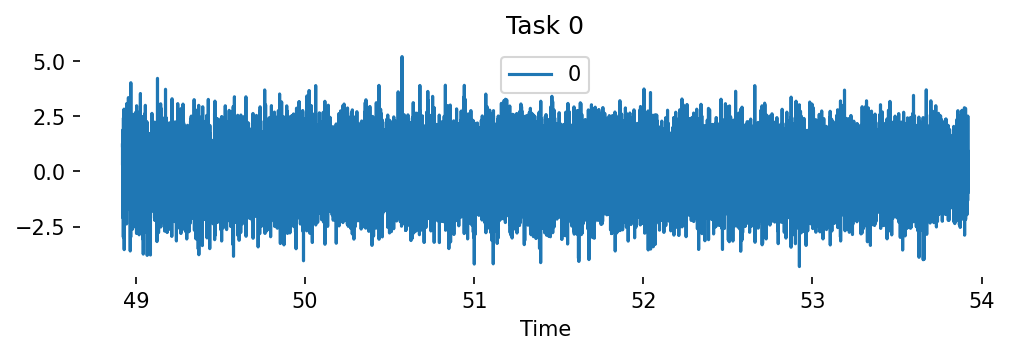

In [41]:
rep_id = 9
task_id = 0
rep_df, rep_st, rep_et = pre.get_single_rep_for_task(eng_dataset, rep_id, task_id)
print(f"rep_st:{rep_st}  rep_et:{rep_et}")
# plot this rep all channels in a single electrode
rep_df.plot(x=TIME_VAR, y=rep_df.columns[0], figsize=(8, 2), legend=True)
plt.legend(ncol=10)
plt.title(f"Task {task_id}")
plt.box(False)



In [42]:
# test function extract rest segment
task_id = 3
rep_id = 1
rep_df,rep_st, rep_et = pre.get_single_rep_for_task(eng_dataset, rep_id, task_id)

# split rep into flexion,  extension, and rest (middle 1 sec prior to flexion)
rep_df_flex = rep_df[rep_df[TIME_VAR] < rep_st + eng_dataset.flex_dur]
rep_df_ext = rep_df[(rep_df[TIME_VAR] >= rep_st + eng_dataset.flex_dur) & (rep_df[TIME_VAR] < rep_et - eng_dataset.rest_dur)]

####### get rest phase from previous rep
rest_start, rest_end,rest_df = pre.extract_rest_for_rep(eng_dataset, task_id, rep_id)


print(f"flex: {rep_df_flex[TIME_VAR].iloc[0]}, {rep_df_flex[TIME_VAR].iloc[-1]}, ext: {rep_df_ext[TIME_VAR].iloc[0]}, {rep_df_ext[TIME_VAR].iloc[-1]}")
print(f"\nTrigger:{ eng_dataset.trig_df[ eng_dataset.trig_df['task_id']==task_id][TRIG_VAR].iloc[rep_id:rep_id+2]}\n")

print(f"rest phase:{rest_start} {rest_end}, {rest_df[TIME_VAR].iloc[0]} - {rest_df[TIME_VAR].iloc[-1]}")

flex: 158.9177, 159.91766666666666, ext: 159.9177, 160.91746666666666

Trigger:31    158.9177
32    163.9175
Name: Trigger, dtype: float64

rest phase:156.9177 157.9177, 156.9177 - 157.91766666666666


In [43]:
# from utils.preprocessing.extract_feat import extract_feature_for_task_rep

#TODO: this function has been replaced by extract_feature_for_task_rep
# flex_power_df, ext_power_df, rest_power_df = pre.extract_feature_for_task_rep(eng_dataset,task_id=4, feat='pow')

NameError: name 'extract_feat_for_task' is not defined

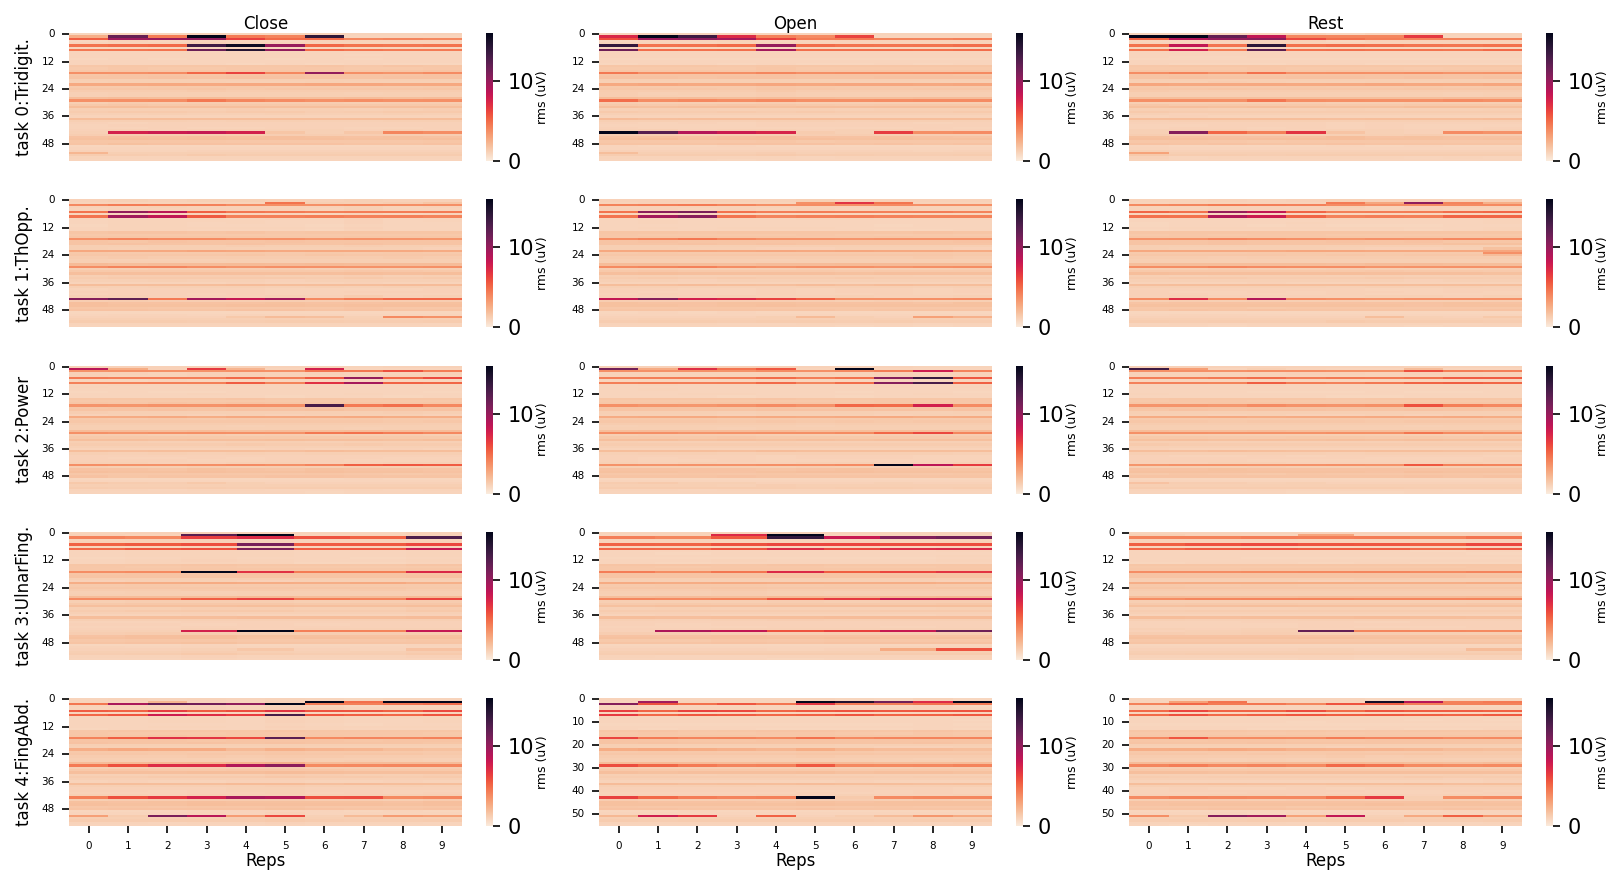

INFO:root:Saving figure to: day1601_rms_wrest_exclude_bad_ch_scale_heatmap_filt_300_2000.png


In [44]:
feat= 'rms'
uplot.create_hmap_across_tasks(eng_dataset, chs_to_exclude=[1,2,43], stat=feat, vmin=0, vmax=16)

In [ ]:
# Replotting excluding all bad channels
uplot.create_hmap_across_tasks(eng_dataset,chs_to_exclude=bad_chs, stat=feat)

In [ ]:
# Plotting with MAV as a feature
uplot.create_hmap_across_tasks(eng_dataset, chs_to_exclude=[1,2,43], stat='mav', vmin=0, vmax=25)

In [ ]:
# Plotting with power as a feature
uplot.create_hmap_across_tasks(eng_dataset, chs_to_exclude=[1,2,43], stat='pow', vmin=0, vmax=500)

In [ ]:
# Re-generating plots without fixing vmin and vmax across all tasks
for stat in ['rms', 'mav','pow']:
    uplot.create_hmap_across_tasks(eng_dataset,chs_to_exclude=[1,2,43], stat=stat)


In [52]:
flex_feat_df

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,Time,feature_window,rep_id
0,1.053020,3.896415,9.920185,1.070393,1.069964,4.730588,0.853413,4.881465,0.979875,1.011132,...,0.918453,1.052337,1.121605,1.254601,1.382094,1.113199,0.938379,0.0,0,1
1,1.007269,4.423040,9.617391,0.998252,1.053899,4.429064,0.898608,4.753526,0.907469,0.965107,...,0.953492,0.945202,1.016439,1.162660,1.272335,0.963846,0.964531,0.1,1,1
2,1.086330,3.743635,10.501729,1.061321,1.024021,4.401001,0.890494,4.035604,0.929598,0.928606,...,0.935276,0.968204,1.019707,1.163421,1.226186,1.018206,1.002726,0.2,2,1
3,1.113980,5.069561,9.270528,1.046727,1.028761,4.901326,0.936615,5.335312,0.986790,0.994303,...,0.913993,1.012136,1.078938,1.191024,1.344666,1.086671,0.954351,0.3,3,1
4,1.129982,19.266686,8.838202,1.097437,1.054206,5.133441,0.833776,4.270764,0.941898,1.031670,...,0.863091,0.961480,1.130272,1.325080,1.406284,0.980267,0.916980,0.4,4,1
5,1.050038,7.868759,9.377957,0.957516,1.046512,5.096256,0.929765,4.090006,0.961544,0.963870,...,0.946157,0.995659,1.031439,1.271534,1.435647,1.040568,0.952217,0.5,5,1
6,1.044774,19.069385,10.592107,1.009162,1.052086,4.836885,0.888019,4.385691,0.953877,0.989286,...,0.902802,0.970136,1.108801,1.287289,1.445654,1.067205,0.899672,0.6,6,1
7,1.060391,18.655997,10.083067,0.970791,1.002203,4.917820,0.866816,5.190409,0.891551,0.979251,...,1.020386,0.958032,1.035012,1.259232,1.375983,1.025484,1.037163,0.7,7,1
8,1.003115,10.129546,9.452825,1.017830,1.000661,5.288414,0.835578,4.720572,0.919279,0.952458,...,0.901242,0.895043,1.003768,1.111539,1.255120,0.916146,0.937461,0.8,8,1
9,1.033237,7.887736,9.607165,0.985578,1.016757,5.363642,0.904695,4.160456,1.054149,1.021795,...,0.953327,0.977827,1.047639,1.246697,1.350024,1.029004,0.986499,0.9,9,1


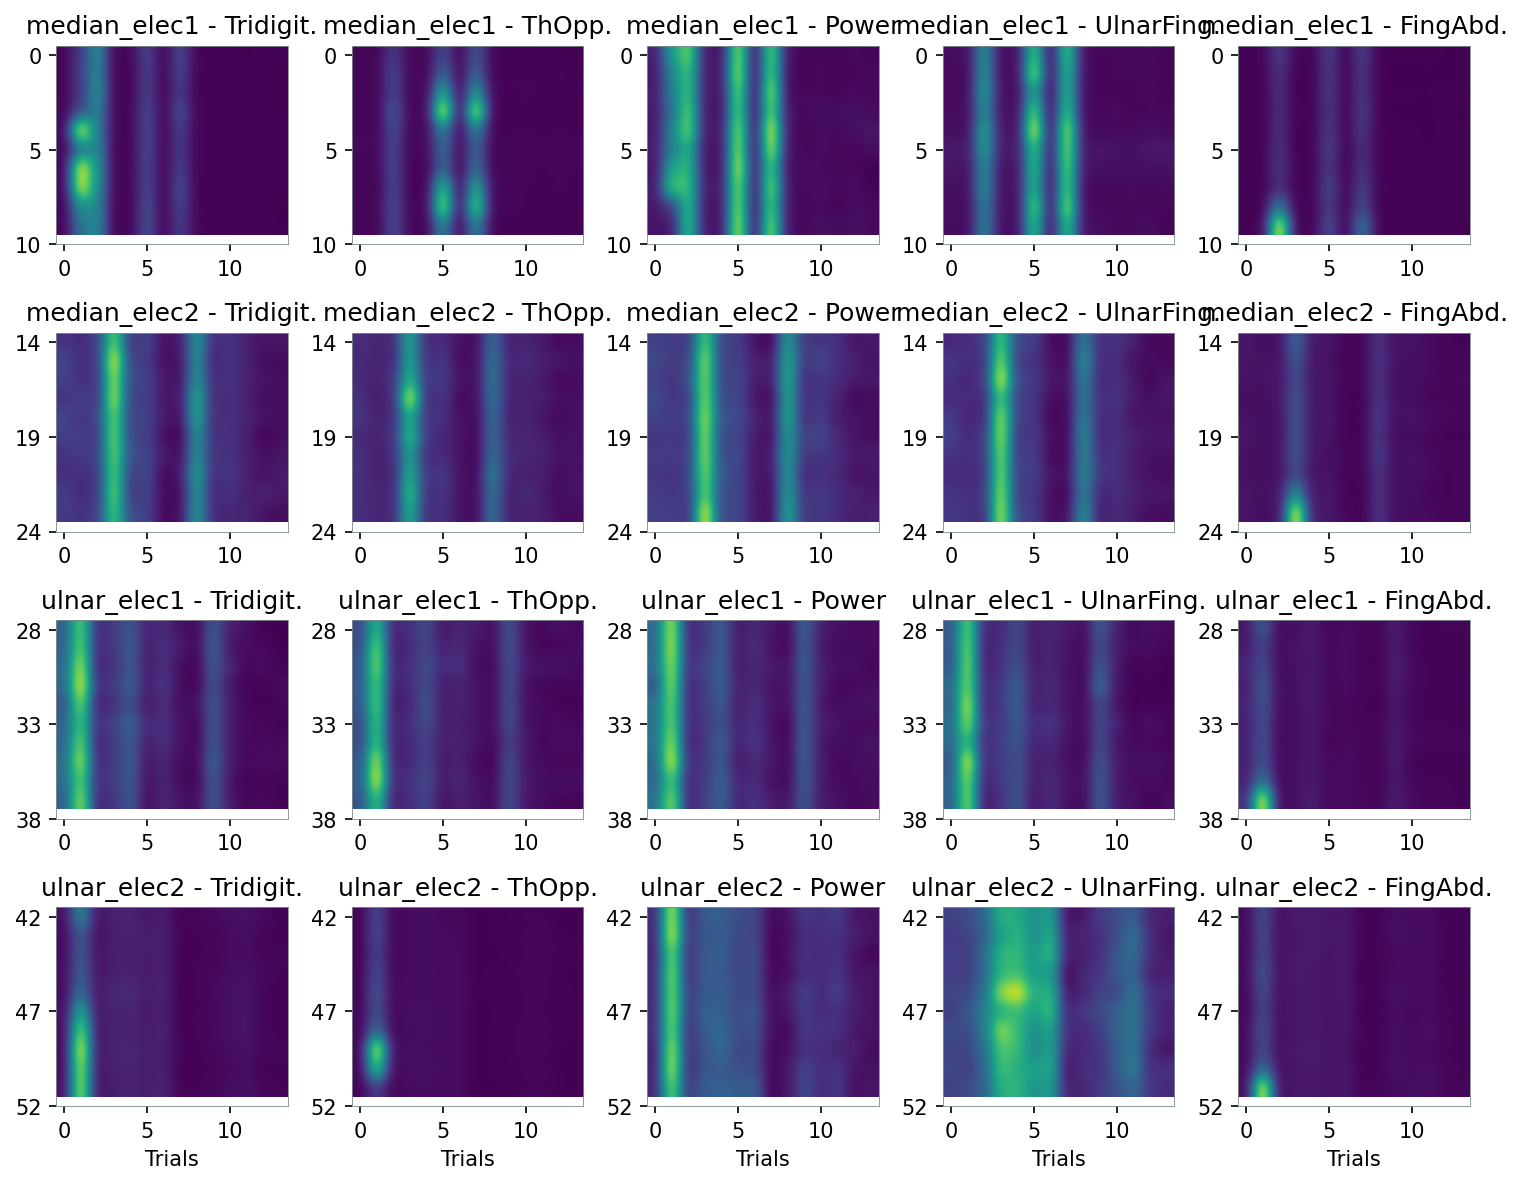

In [53]:
# MANPLOT: Plot spatial activation map: 4 electrodes, 14 channels in each, x axis time and y axis channel
# First assuming the feat is computed over the entire duration and all reps 

feat = 'rms'
interp = 'gaussian' #'bicubic'  #'none' is default
gs = gridspec.GridSpec(nrows=eng_dataset.n_electrodes, ncols=len(eng_dataset.task_order))

fig = plt.figure(figsize=(10, 8))
for task_id, task_n in enumerate(eng_dataset.task_order):
    for row, elec in enumerate(range(eng_dataset.n_electrodes)):
        nerve_elec = list(Nerve)[elec]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]
        ax = fig.add_subplot(gs[row, task_id])

        # flex_feat_df: shape (n_channels, n_trials) (56, 9)
        flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep(eng_dataset, task_id, rep_id, feat, wind_size=0.1, overlap_perc=0)

        ax.imshow(flex_feat_df[ch_group], aspect='auto', cmap='viridis', interpolation=interp)
        ax.set_title(f"{nerve_elec.value} - {task_n}")
        if row == eng_dataset.n_electrodes -1:
            ax.set_xlabel('Trials')
        ax.set_yticks(np.arange(0, len(ch_group), 5), labels = ch_group[::5])
fig.tight_layout()

In [ ]:
# MANPLOT: Plot spatial activation map: 4 electrodes, 14 channels in each, x axis time and y axis channel
# Second assuming the feat is computed over the entire duration and single rep
feat = 'rms'
interp = 'none' #'bicubic'  #'none' is default
trial_id = 4
gs = gridspec.GridSpec(nrows=eng_dataset.n_electrodes, ncols=len(eng_dataset.task_order))

fig = plt.figure(figsize=(10, 8))
for col, task_id in enumerate(eng_dataset.task_order):
    for row, elec in enumerate(range(eng_dataset.n_electrodes)):
        nerve_elec = list(Nerve)[elec]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]
        ax = fig.add_subplot(gs[row, col])

        # flex_feat_df: shape (n_channels, n_trials) (56, 9)
        flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feat_for_task_rep(eng_dataset, col, feat)
        ax.imshow(flex_feat_df.iloc[ch_group][trial_id].to_numpy().reshape(len(ch_group),1), aspect='auto', cmap='viridis', interpolation=interp)
        ax.set_title(f"{nerve_elec.value} - {task_id}")
        # if row == eng_dataset.n_electrodes -1:
        #     ax.set_xlabel('Trials')
        ax.set_yticks(np.arange(0, len(ch_group), 5), labels = ch_group[::5])
fig.tight_layout()
 


In [ ]:
# MANPLOT:Plot spatial activation map: 4 electrodes, 14 channels in each, x axis time and y axis channel
# Lastly: plot feature in time

feat = 'power'
interp = 'gaussian'  # 'bicubic'  #'none' is default
bin_width = 0.1      # in sec
overlap_perc = 0.5
stride = bin_width - overlap_perc * bin_width    # duration in sec
min_periods = 0  # wind_size

Gest = namedtuple('gesture', ['id', 'phase'])
sel_gest = [Gest(0, FLX_PHASE), Gest(1, FLX_PHASE), Gest(
    2, FLX_PHASE), Gest(3, FLX_PHASE), Gest(4, FLX_PHASE)]


gs = gridspec.GridSpec(nrows=eng_dataset.n_electrodes,
                       ncols=len(eng_dataset.task_order))

fig = plt.figure(figsize=(8, 5))

rep_id = 1
vmax_all = 10     # For RMS feature rep2: 10 rep0: 5
vrange = {'median_elec1': (0, vmax_all),
         'median_elec2': (0,vmax_all),
         'ulnar_elec1': (0,vmax_all),
         'ulnar_elec2': (0,vmax_all)}
normalize = False
drop_bad_chs = bad_channels   # default is []
for col, task_id in enumerate(eng_dataset.task_order):
    for row, elec in enumerate(range(eng_dataset.n_electrodes)):
        nerve_elec = list(Nerve)[elec]
        ch_group = eng_dataset.nerves_ch_group[nerve_elec]
        ax = fig.add_subplot(gs[row, col])
        # flex_feat_df: shape (n_windows, n_channels)
        flex_feat_df, ext_feat_df, rest_feat_df = pre.extract_feature_for_task_rep(eng_dataset, col, rep_id, feature=feat,
                                                                           wind_size=0.2, overlap_perc=overlap_perc)
        if len(drop_bad_chs)>0:
            ch_group = [ch for ch in ch_group if ch not in drop_bad_chs]

        if normalize:
            vmin=vrange[nerve_elec.value][0]
            vmax=vrange[nerve_elec.value][1]
        else:
            vmin= None
            vmax = None
        im = ax.imshow(flex_feat_df[ch_group].T, aspect='auto', cmap='viridis', interpolation=interp, vmin=vmin, vmax=vmax)
        if col==eng_dataset.n_tasks-1 or not normalize:
            cbar = plt.colorbar(im, ax=ax)
        ax.set_title(f"{nerve_elec.value}", fontsize=8)
        ax.set_xticks(np.arange(0, len(flex_feat_df), 4), labels=np.round(flex_feat_df[TIME_VAR].to_numpy()[::4],2))
        ax.set_yticks(np.arange(0, len(ch_group), 5), labels=ch_group[::5])

        if row == eng_dataset.n_electrodes - 1:
            ax.set_xlabel('Time (s)')
 
        if col ==0:
            ax.set_ylabel('Channels')
        else:
            ax.set_yticklabels([])
fig.suptitle(f"REP# {rep_id}")

fig.text(0.1, 1, f"{eng_dataset.task_order[0]}")
fig.text(0.3, 1, f"{eng_dataset.task_order[1]}")
fig.text(0.5, 1, f"{eng_dataset.task_order[2]}")
fig.text(0.65, 1, f"{eng_dataset.task_order[3]}")
fig.text(0.85, 1, f"{eng_dataset.task_order[4]}")
fig.tight_layout()

In [ ]:
# from utils.svm import prepare_input_df
# from constants import *
# # optimizing some memory
# # eng_dataset._detete_raw_data()

# wind_size= 0.2
# overlap_perc = 0.5
# feature='rms'
# organize_strat = 'flx_vs_ext_separate'
# input_df, labels_map = prepare_input_df(eng_dataset, feature, organize_strat,  wind_size, overlap_perc)

# input_df.groupby(['class_label', 'rep_id'])[FEAT_WIN_COL].count()

In [ ]:
#MANPLOT: Barplot of mean feature across all reps + std
# average stat across all reps
avg_flex, std_flex = {}, {}
avg_ext, std_ext = {} ,{}
avg_rest, std_rest = {}, {}


bwidth = 0.3


# loop over different stats
fig = plt.figure(figsize=(10, 2))

gs = gridspec.GridSpec(nrows=1, ncols=3)

for feat_i, feat in enumerate(["rms", "mav","pow"]):

    # average stat across all channels
    for task_id in range(N_TASKS):
        # feat_flex_df, feat_ext_df, feat_rest_df = compute_task_stat(filt_df, task_id, eng_dataset.trig_df, eng_dataset.task_rep_count,
        #                                                              flx_dur, ext_dur, rest_dur, stat=feat)
        feat_flex_df, feat_ext_df, feat_rest_df = extract_feat_for_task(eng_dataset, task_id, feat=feat)
        avg_flex[task_id] = feat_flex_df.mean(axis=1).mean()
        avg_ext[task_id] = feat_ext_df.mean(axis=1).mean()
        avg_rest[task_id] = feat_rest_df.mean(axis=1).mean()

        std_flex[task_id] = feat_flex_df.std(axis=1).std()
        std_ext[task_id] = feat_ext_df.std(axis=1).std()
        std_rest[task_id] = feat_rest_df.std(axis=1).std()

        if feat== 'pow':
            print(f"{task_id}  flex: {avg_flex[task_id]:.2f} +- {std_flex[task_id]:.2f}, ext: {avg_ext[task_id]:.2f} +- {std_ext[task_id]:.2f}, rest: {avg_rest[task_id]:.2f} +- {std_rest[task_id]:.2f}")

    # plot the average stat across all channels
    ax = fig.add_subplot(gs[feat_i])
    ax.bar(np.arange(N_TASKS), avg_flex.values(),label=FLX_PHASE, width=bwidth, )#COLOR_DICT['midnight_blue']) #9d02d7, color= '#008176'
    ax.bar(np.arange(N_TASKS)+ bwidth, avg_ext.values(), label=EXT_PHASE, width=bwidth, color= COLOR_DICT['viz_orange'])
    ax.bar(np.arange(N_TASKS)+ 2*bwidth, avg_rest.values(), label=REST_PHASE, width=bwidth, color= COLOR_DICT['green_sea'], alpha=0.7)

    if feat != 'pow':
        ax.errorbar(np.arange(N_TASKS), avg_flex.values(), yerr=list(std_flex.values()), fmt='none', ecolor=COLOR_DICT['midnight_blue'], capsize=2,alpha=0.7 )
        ax.errorbar(np.arange(N_TASKS)+ bwidth, avg_ext.values(), yerr=list(std_ext.values()), fmt='none', ecolor=COLOR_DICT['midnight_blue'], capsize=2, alpha=0.7)
        ax.errorbar(np.arange(N_TASKS)+ 2*bwidth, avg_rest.values(), yerr=list(std_rest.values()), fmt='none', ecolor=COLOR_DICT['midnight_blue'], capsize=2,alpha=0.7)

    # if feat == 'mav':
    #     plt.legend(ncol=3,loc='upper left')
    ax.set_xticks(np.arange(N_TASKS)+bwidth, TASK_ORDER, rotation=45,)

    if feat == 'pow':
        # ax.set_yscale('log')
        plt.ylabel(r'{feat} [$\mu V^2$]'.format(feat=feat), labelpad=0.1)
    else:
        plt.ylabel(r'{feat} [$\mu V$]'.format(feat=feat), labelpad=0.1)
        plt.ylim([0,4.25])
    plt.box(False)

    # plt.tight_layout()
handles, labels_map = ax.get_legend_handles_labels()
fig.legend(handles, labels_map, loc='upper center', ncol=3, frameon=False)

# fig.text(0.5, 0.91, f"Average across Reps ([{pipeline['bp_cutoff_freq'][0]} - {pipeline['bp_cutoff_freq'][1]}])",  ha='center', va='center', fontsize=7)

# fig.text(0.5, 0.91, f"Mean feature across repetition ",  ha='center', va='center', fontsize=7)
plt.show()
# save the figure
fig.savefig(os.path.join(FIG_DIR, f"day{day}{session}_mean_chs_reps_barplot_filt.png"), dpi=300, bbox_inches='tight')


In [ ]:

def create_scatter_feat_plot(ax, feat, eng_dataset, xy_ch= [17,0], plot_phase= 'flex'):
    markers = ["p", "^", "o",  "s", "*" ]
    x_ch = xy_ch[0]
    y_ch = xy_ch[1]
    # fig, ax = plt.subplots(figsize=(3, 3))
    
    for task_id in range(N_TASKS):
        flex_df, ext_df, rest_df = extract_feat_for_task(eng_dataset, task_id, feat=feat)

        if plot_phase == 'flex':
            plot_df = flex_df
        elif plot_phase == 'ext':
            plot_df = ext_df
        elif plot_phase == 'rest':
            plot_df = rest_df

        reps_median_mean = plot_df.iloc[x_ch, :].mean()
        reps_ulnar_mean = plot_df.iloc[y_ch, :].mean()

        ax.scatter(plot_df.iloc[x_ch, :], plot_df.iloc[y_ch, :], label=f'task {task_id}', marker=markers[task_id], s=5,
                   color =list(COLOR_DICT.values())[task_id], alpha=0.6)
        # add mean in bigger marker
        ax.scatter(reps_median_mean, reps_ulnar_mean, marker=markers[task_id], s=10, color =list(COLOR_DICT.values())[task_id])
    plt.box(False)
    plt.legend()
    plt.xlabel(f"median nerve Ch:{x_ch}")
    plt.ylabel(f"ulnar nerve Ch:{y_ch}")
    plt.title(f"Phase:{plot_phase}  - Feat:{feat}")


In [ ]:
# create a scatter plot of the power of the first channel across tasks
fig = plt.figure(figsize=(8,3))
feat = 'pow'

ch_median = 1
ch_ulnar = 43
ax = fig.add_subplot(131)
create_scatter_feat_plot(ax, feat, eng_dataset, xy_ch= [ch_median, ch_ulnar], plot_phase= 'flex')

ax = fig.add_subplot(132)
create_scatter_feat_plot(ax, feat, eng_dataset,xy_ch= [ch_median, ch_ulnar], plot_phase= 'ext')

ax = fig.add_subplot(133)
create_scatter_feat_plot(ax, feat, eng_dataset, xy_ch= [ch_median, ch_ulnar], plot_phase= 'rest')

fig.tight_layout()



In [ ]:
# save figure
fig.savefig(os.path.join(FIG_DIR, f"day{day}{session}_{feat}_scatter_median_{ch_median}_ulnar_{ch_ulnar}_filt_{pipeline['bp_cutoff_freq'][0]}_{pipeline['bp_cutoff_freq'][1]}.png"), dpi=300, bbox_inches='tight')

# 4. Test Classification of tasks: one vs. rest


- One-vs-all: trains one clf per class
- One-vs-one: a separate classifier per pair.

In [ ]:
# # Prepare dataset for training
# # create a dataframe with the features and the labels
# def create_feat_df(eng_dataset, clf_classes, feat_list=['pow']):
#     """
#     Creates a dataframe with the features and the labels. 
#     clf_classes (string): defines the classes we would like to discriminate. Can be 'flx_vs_ext_combined' or 'flx_vs_ext_separate' or 'flx_vs_ext_vs_rest'. 

#         - 'flx_vs_ext_combined': combine flexions of all tasks into one class and extensions of all tasks into another class. In total: 2 classes + rest
#         - 'flx_vs_ext_separate': considers each flexion and extension phases of each gesture as 2 distince classes. Since we have 5 tasks, we have 10 classes + rest in total if you select this method.
#         - 'flx_and_ext_separate': considers flexion and extension phases of each gesture as a single class. For the 5 tasks, we would then have 5 classes + rest in total.
#     """
    
#     feat_df = pd.DataFrame()
#     for task_id in range(len(eng_dataset.task_order)):
#         for feat in feat_list:
#             # flex_df, ext_df, rest_df = compute_task_stat(df, task_id, trig_df, reps_dict, flx_dur, ext_dur, rest_dur, stat=feat)
#             flex_df, ext_df, rest_df = extract_feat_for_task(eng_dataset, task_id, feat=feat)
#             # transpose
#             flex_df = flex_df.T
#             ext_df = ext_df.T
#             rest_df = rest_df.T

#             # add labels
#             if clf_classes == 'flx_vs_ext_combined':  
#                 REST_LABEL = 2
#                 FLX_LABEL = 0
#                 EXT_LABEL = 1
#                 LABELS = {FLX_LABEL: 'Close', EXT_LABEL: 'Open', REST_LABEL: 'Rest'}
#                 flex_df['label'] = [FLX_LABEL for rep in range(eng_dataset.task_rep_count[task_id])]
#                 ext_df['label'] = [EXT_LABEL for rep in range(eng_dataset.task_rep_count[task_id])]
     
#             elif clf_classes == 'flx_and_ext_separate': 
#                 flex_df['label'] = [task_id for rep in range(eng_dataset.task_rep_count[task_id])]
#                 ext_df['label'] = [task_id for rep in range(eng_dataset.task_rep_count[task_id])]
#                 REST_LABEL = 5
#                 LABELS = {0: "Tripod", 1: "ThOpp", 2: "Power", 3: "UlnarFing.", 4: "FingAbd.", REST_LABEL: "Rest"}

#             elif clf_classes == 'flx_vs_ext_separate': 
#                 flex_df['label'] = [task_id*2 for rep in range(eng_dataset.task_rep_count[task_id])]
#                 ext_df['label'] = [task_id*2+1 for rep in range(eng_dataset.task_rep_count[task_id])]
#                 REST_LABEL = 5 * 2
#                 LABELS = {0: "Tripod Close", 1:"Tripod Open", 
#                           2: "ThOpp. Close", 3: "ThOpp. Open", 
#                           4: "Power Close", 5: "Power Open", 
#                           6: "UlnarFing. Close", 7:"UlnarFing. Open", 
#                           8: "FingAbd. Close ", 9:"FingAdd. Open", 
#                           REST_LABEL: "Rest"}

#             rest_df['label'] = [REST_LABEL for rep in range(eng_dataset.task_rep_count[task_id])]

#             # concat
#             feat_df = pd.concat([feat_df, flex_df, ext_df, rest_df], axis=0)
#     return feat_df, LABELS

## Unfold each rep in time (train on bins)

In [ ]:
# optimizing some memory
# eng_dataset._detete_raw_data()
wind_size= 0.2
overlap_perc = 0.5
feature='rms'
organize_strat = 'flx_vs_ext_separate'
input_df, labels_map = classify.prepare_input_df(eng_dataset, feature, organize_strat,  wind_size, overlap_perc)

input_df.groupby(['class_label', 'rep_id'])[FEAT_WIN_COL].count()

In [ ]:
Gest_namedtup = namedtuple('gesture', ['id', 'phase'])

# create a select_class from sel_gest_phase
def encode_gest_phase(sel_gest_phase: List[Gest_namedtup], labels_map: Dict[int, str]):
    """
    Encodes class labels from the selected gestures considering the phase as well.

    """
    enc_classes = []
    enc_class_labels = []
    for sel_gest_item in sel_gest_phase:
        g = eng_dataset.task_order[sel_gest_item.id]
        phase = sel_gest_item.phase
        print(sel_gest_item.id, g)
        # look for this g in the labels_map values
        for k, v in labels_map.items():
            if f"{g} {phase}" in v:
                enc_classes.append(k)
                enc_class_labels.append(v)
    return enc_classes, enc_class_labels



In [ ]:
bad_channels, bad_channels_std = pre.detect_bad_channels(eng_dataset, std_threshold=5)
print(f"Bad channels:{bad_channels}\nBad channels std:{np.round(bad_channels_std,3)}")

In [ ]:
# get the average count of feat_win per class across reps
# avg_win_per_class = input_df.groupby([LABEL_COL],as_index=True)[FEAT_WIN_COL].count() / input_df.groupby([LABEL_COL],as_index=True)[REP_ID_COL].nunique()
# print(avg_win_per_class)

# input_df.groupby(['class_label'],as_index=True)[REP_ID_COL].nunique()
# input_df.groupby([LABEL_COL, REP_ID_COL],as_index=True)[FEAT_WIN_COL].count() 

In [ ]:
labels_map, input_df[LABEL_COL].unique()

In [ ]:
# quick check on input_df vs temporal_df
from utils.preprocess_analog import extract_temporal_feat

sel_gest_phase = [Gest_namedtup(0, 'Open'),
                  Gest_namedtup(1, 'Close'),
                  # Gest_namedtup(2,'Close'),
                  Gest_namedtup(3, 'Close'),
                  Gest_namedtup(4, 'Close')]

feat = 'pow'
overlap_perc = 0.5
wind_size=0.1
stride = overlap_perc * wind_size
min_periods = 0

# calculate input_df
# input_df has all classes
input_df, labels_map = classify.prepare_input_df(eng_dataset, feature, organize_strat,  wind_size, overlap_perc)
select_class, select_class_labels = encode_gest_phase(sel_gest_phase, labels_map)


# calculate temporal_df
# avg_df_all has only the selected classes 
avg_df_all = extract_temporal_feat(eng_dataset, 
                      sel_gest_phase, 
                      wind_size, 
                      stride, 
                      min_periods, 
                      feat='pow',  
                      
                      remove_bad_chs=[])

avg_df_all.columns

In [ ]:

print(avg_df_all['label'].unique())
# print(input_df[LABEL_COL].unique())
print(select_class)

input_df_to_avg = {v:sel_gest_phase[avg_df_all['label'].unique()[i]].id for i,v in enumerate(select_class)}
input_df_to_avg



In [ ]:
# get a single class from input_df
class_label = 1
class_label_in_avg = input_df_to_avg[class_label]
rep_id = 1

# get the feature for this class
aux_input_df = [TIME_VAR, FEAT_WIN_COL, LABEL_COL, REP_ID_COL]
aux_avg_df = [TIME_VAR, 'label', REP_ID_COL]

class_df_from_input = input_df[(input_df[LABEL_COL]==class_label) & (input_df[REP_ID_COL]==rep_id)]
class_df_from_avg = avg_df_all[(avg_df_all['label']==class_label_in_avg) & (avg_df_all[REP_ID_COL]==rep_id)]
print(f"class_df_from_input:{class_df_from_input.shape}")
print(f"class_df_from_avg:{class_df_from_avg.shape}")

# check if the dataframes match
assert class_df_from_input.shape[0] == class_df_from_avg.shape[0], "Number of windows do not match"
assert class_df_from_input.shape[1]- len(aux_input_df) == class_df_from_avg.shape[1]- len(aux_avg_df), "Number of channels do not match"
df1 = class_df_from_input.drop(columns=aux_input_df).reset_index(drop=True)
df2 = class_df_from_avg.drop(columns=aux_avg_df).reset_index(drop=True)
assert df1.equals(df2), "Dataframes do not match"
df1.compare(df2,keep_equal=False)

# plot the feature for this class and a single channel
debug_ch =0
plt.figure(figsize=(8,3))
plt.plot(class_df_from_input[debug_ch], label='from feat fn', alpha=0.6)
plt.plot( np.arange(class_df_from_input[debug_ch].shape[0]), 
         class_df_from_input[debug_ch], 
         label='from input_df', alpha=0.8, linestyle='dotted')
plt.legend()

In [ ]:
# comparae across classes
glob_rep_counter=0

# I need c_avg to get the relative class_label in avg_df_all.
# there the class label is just ordered values from 0 to n_sel_classes
for c_avg, class_label in enumerate(input_df_to_avg.keys()):
    class_label_in_avg = input_df_to_avg[class_label]
    nreps = eng_dataset.task_rep_count[class_label_in_avg]
    print(f"Comparing class_label:{class_label} with class_label_in_avg:{class_label_in_avg} nreps:{nreps}")
    for rep_id in range(nreps):

        class_df_from_input = input_df[(input_df[LABEL_COL]==class_label) & (input_df[REP_ID_COL]==rep_id)]
        class_df_from_avg = avg_df_all[(avg_df_all['label']==c_avg) & (avg_df_all[REP_ID_COL]==rep_id+glob_rep_counter)]
        
        df1 = class_df_from_input.drop(columns=aux_input_df).reset_index(drop=True)
        df2 = class_df_from_avg.drop(columns=aux_avg_df).reset_index(drop=True)
        print(f"class_df_from_input:{class_df_from_input.shape}   from avg_df:{class_df_from_avg.shape}")

        assert df1.equals(df2), f"Dataframes do not match class_label:{class_label} rep_id:{rep_id}"
        df1.compare(df2,keep_equal=False)
    glob_rep_counter+=nreps
    print(f"\n{glob_rep_counter}")


In [ ]:
feature = 'power'
wind_size = 0.100
overlap_perc = 0.5
organize_strat = 'flx_vs_ext_separate'

input_df, labels_map = classify.prepare_input_df(eng_dataset, feature, organize_strat,  wind_size, overlap_perc)
avg_win_per_class = input_df.groupby([LABEL_COL],as_index=True)[FEAT_WIN_COL].count() / input_df.groupby([LABEL_COL],as_index=True)[REP_ID_COL].nunique()
print(f"Average number of windows per class\n{avg_win_per_class}\n")


# Select only few classes from all for classification
sel_gest_phase = [Gest_namedtup(0, 'Open'),
                  Gest_namedtup(1, 'Close'),
                  # Gest_namedtup(2,'Close'),
                  Gest_namedtup(3, 'Close'),
                  Gest_namedtup(4, 'Close')]

select_class, select_class_labels = encode_gest_phase(sel_gest_phase, labels_map)

print(f"Selected classes:{select_class} with names:\n{select_class_labels}")
results_df = classify.fit_svm(input_df, labels_map, select_class, annotate_cm=False,
                              seed=1,
                              is_temporal=True,
                              k_cv=5,
                              bad_channels=bad_channels, #old code [1,2,43]
                              bin_width=wind_size,
                              bin_stat=feature,
                              exp_var=None)

In [ ]:
results_df.mean()

In [ ]:
print(f"Mean balanced acc across all classes:{np.round(results_df['acc_val'].mean(),4)*100} +- {np.round(results_df['acc_val'].std(),4)*100}")

## Consider Flexion vs Extension

In [ ]:
# consider flex vs. ext
input_df, labels_map = create_feat_df(filt_df, trig_df_post, n_reps, flx_dur, ext_dur, rest_dur, feat_list=['pow'], clf_classes='flx_vs_ext_combined')
print(Counter(input_df['label']), "\n", labels_map)

select_class= [0,1]
results_df = train_svm(input_df, labels_map, select_class, pipeline, save_fig=False)

# # save  results_df 
# filename = f"day{day}{session}_{feat}_acc_df_linear_{list(labels.values())}_filt_{pipeline['bp_cutoff_freq'][0]}_{pipeline['bp_cutoff_freq'][1]}.png"

# dfi.export(results_df, os.path.join(CLF_FIG, filename))
# print(filename)

In [ ]:
# repeat for all 11 classes
input_df, labels_map = create_feat_df(filt_df, trig_df_post, n_reps, flx_dur, ext_dur, rest_dur, feat_list=['pow'], clf_classes='flx_vs_ext_separate')
print(Counter(input_df['label']), "\n", labels_map)

select_class = list(labels_map.keys())# np.arange(10)  choosing the first 10 labels means we are excluding the 5th label (rest)
selected_labels_map = filter_dict(labels_map, select_class)
results_df = train_svm(input_df, labels_map, select_class, pipeline, save_fig=True, annotate_cm=False)


# # save results_df
# filename = f"day{day}{session}_{feat}_acc_df_linear_{list(label_to_gest.values())}_filt_{pipeline['bp_cutoff_freq'][0]}_{pipeline['bp_cutoff_freq'][1]}.png"

# dfi.export(results_df, os.path.join(CLF_FIG, filename))
# print(filename)

# Plot feature for smaller windows across the entire trial

The idea here is to see how the feature evolves across the entire trial duration and whether I can leverage this information for classification.

In the previous section, I computed the feature over the entire trial duration and used that as input to the CLF. This is not very accurate; I should be able to output a prediction in 100 - 150 ms.

In [ ]:
# compute statistics over time
rep = 0
task_id = 3
bin_width = 0.4  #0.1 # in seconds
bin_stat = 'pow' # 'mav' or 'pow'

# bins_flx_stat, bins_ext_stat, bins_rest_stat, bins_rg_dict = compute_stat_over_time(filt_df, trig_df_post, n_reps, rep, task_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)
bins_stat, bins_rg = compute_stat_in_time_for_rep_id(filt_df, trig_df_post, n_reps, rep, task_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, combine_flx_ext=True)
bins_rg.shape


In [ ]:
fig = plt.figure(figsize=(15,30))
gs = gridspec.GridSpec(10, 5)

bin_width = 0.1 # in sec

# get overall min and max power for normalization
pow_max = 0
pow_min = 10000


# post-looking at pow min and max excluding ulnar finger + bin_width = 0.5
vmin= 0
vmax= 2500

for task_id, task_id in enumerate(range(N_TASKS)):
    for row, rep_id in enumerate(range(n_reps[task_id])):
        cbar = True
        ylabel= None
        xlabel = None
        title = None
        ax = fig.add_subplot(gs[row, task_id])
        # bins_stat, bins_rg = compute_stat_over_time(filt_df, trig_df_post, n_reps, rep_id, task_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, combine_flx_ext=True)
        bins_stat, _,_, bins_rg = compute_stat_in_time_for_rep_id(filt_df, trig_df_post, n_reps, rep_id, task_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, combine_flx_ext=False)

        # remove bad chs
        bins_stat = bins_stat.drop([1,2,43], axis=1)
        
        if  task_id==0:
            ylabel = f'Time [s] - Rep# {rep_id+1}'
        if row == 9:  # last row
            xlabel = 'Ch'
        if row == 0:
            title = f'{TASK_ORDER[task_id]}'

        if task_id != 3:       
            pow_max  = np.max([pow_max, bins_stat.max().max()])
            pow_min = np.min([pow_min, bins_stat.min().min()])
        
        yticks_label = bins_rg[FLX_PHASE].round(1)
        plot_heatmap(bins_stat, title, ax, cbar_label='Power (uV^2)', cbar=cbar, ylabel=ylabel, xlabel=xlabel, yticks_label=yticks_label)
        

# add common title
fig.text(0.5, 0.90, f'Bin size {bin_width} sec', ha='center', va='center', fontsize=8)
plt.show()
# save fig
filename = f"day{day}{session}_{feat}_heatmap_{bin_stat}_{bin_width}_sec_filt_{pipeline['bp_cutoff_freq'][0]}_{pipeline['bp_cutoff_freq'][1]}.png"
# fig.savefig(os.path.join(FIG_DIR, filename), dpi=300)
filename

In [ ]:
Gest = namedtuple('gesture', ['id', 'phase'])
# sel_gest = [Gest(0,'Open'),Gest(1,'Close'),Gest(2,'Close'), Gest(3,'Close'),Gest(4,'Close')] 
sel_gest = [Gest(0,'Open'),Gest(1,'Close'), Gest(3,'Close'),Gest(4,'Close')] 


bin_width = 0.1 # in sec
bin_stat = 'pow'
test_df = compute_stat_in_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)

In [ ]:
m = test_df[test_df['label']==1]
m.drop_duplicates(subset=['rep_id'], keep='last', inplace=False).index -1

In [ ]:
test_df.columns

In [ ]:
fig = plt.figure(figsize=(9,3))


# gs = gridspec.GridSpec(2, int(len(sel_gest)/2))
gs = gridspec.GridSpec(1, len(sel_gest))

g_list = []
for g, sel_gest_item in enumerate(sel_gest):

    temp = test_df[test_df['label']==g]
    first_index = temp.index[0]
    bins_ids = temp.drop_duplicates(subset=['rep_id'], keep='last', inplace=False).index
    bins_ids = bins_ids - first_index
    g_list.append(sel_gest_item.id)

    # test_df = test_df.drop([1,2,43], axis=1)
    bins_stat = test_df[test_df['label']==g].drop(['label'], axis=1)
    print(f"{g}   {sel_gest_item}  {bins_stat.shape}")
    ax = fig.add_subplot(gs[g])

    g_phase = sel_gest_item.phase
    yticks_label = bins_stat[TIME_VAR].round(1)

    # get index of the bins per rep
  
    # remove time col
    bins_stat = bins_stat.drop([TIME_VAR], axis=1)
    if g == 0:
        ylabel = 'Time [sec]'
    else:
        ylabel = ''
    if g == len(sel_gest)-1:
        cbar= True
        cbar_label = r'Pwer [$\mu$ $V^2$]'
    else:
        cbar = False
        cbar_label = None

    # ylabel='Time [sec]'
    # if g==len(sel_gest)-1 or g==1:
    #     cbar = True
    #     cbar_label=r'Pwer [$\mu$ $V^2$]'
    # else:
    #     cbar = False
    #     cbar_label = None

    plot_heatmap(bins_stat, f'{TASK_ORDER[sel_gest_item.id]}  {g_phase}', ax, cbar_label=cbar_label,cbar=cbar, ylabel=ylabel, xlabel='Channels', 
                 yticks_label=yticks_label, xticks_label=bins_stat.columns,
                 ticks_step=5, vmin=0, vmax=4.5,hor_lines=list(bins_ids))
# fig.text(0.5, 0.01, f'Channels', ha='center', va='center', fontsize=8)
plt.show()
filename = f"{bin_stat}_single_row_heatmap_{g_list}_{bin_stat}_{int(bin_width*1000)}_msec_tripod_open.png"
# fig.savefig(os.path.join(FIG_DIR, filename), dpi=300)



In [ ]:
yticks_label
bins_stat.columns

In [ ]:
# zoom in on a single rep: trial # 3 (index 2)
fig = plt.figure(figsize=(9,3))
gs = gridspec.GridSpec(1, len(sel_gest))

g_list = []
bin_width= 0.1
rep_id = 2
for g, sel_gest_item in enumerate(sel_gest):
    task_id = sel_gest_item.id
    bins_stat, _,_, bins_rg = compute_stat_in_time_for_rep_id(filt_df, trig_df_post, n_reps, rep_id, task_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, combine_flx_ext=False)
    print(f"{g}   {sel_gest_item}  {bins_stat.shape}")

    # drop bad columns
    bins_stat = remove_bad_chs(bins_stat)

    # append the time var
    g_phase = sel_gest_item.phase

    if g_phase == FLX_PHASE:
        bins_stat[TIME_VAR] = bins_rg[FLX_PHASE][:-1]
    elif g_phase == EXT_PHASE:
        bins_stat[TIME_VAR] = bins_rg[EXT_PHASE][:-1]
    else:
        raise ValueError(f"phase {g_phase} not recognized")

    ax = fig.add_subplot(gs[g])

    yticks_label = bins_stat[TIME_VAR].round(1)
    bins_stat = bins_stat.drop([TIME_VAR], axis=1)

    if g == 0:
        ylabel = 'Time (s)'
    else:
        ylabel = ''
    
    if g == len(sel_gest)-1:
        cbar = True
        cbar_label = 'Power (dB)'
    else:
        cbar = False
        cbar_label = None

    ax = fig.add_subplot(gs[0,g])
    plot_heatmap(bins_stat, f'{TASK_ORDER[task_id]}  {g_phase}', ax, cbar_label=cbar_label,cbar=cbar, 
                 ylabel=ylabel, xlabel='Channels', 
                 yticks_label=yticks_label, xticks_label=bins_stat.columns,
                 ticks_step=1, vmin=0, vmax=4.5)


plt.show()

In [ ]:
# quick test whether we can classify those time bins
import itertools

LABELS = {0: "pinch", 1: "opp", 2: "power", 3: "ulnar", 4: "abd"}
Gest = namedtuple('gesture', ['id', 'phase'])

sel_gest = [Gest(0,'Open'),Gest(1,'Close'), Gest(2,'Close'), Gest(3,'Close'),Gest(4,'Close')] 

rep_list = list(itertools.chain(*[[sel_gest_item.id]*n_reps[sel_gest_item.id] for sel_gest_item in sel_gest]))  # used to split the reps into train and test

# train svm on those bins
labels_map = test_df['label']
test_df = test_df.drop([TIME_VAR], axis=1)
select_class = [0,1,3,4]#np.unique(labels)
gest_name = [f'{LABELS[i.id]}_{i.phase}' for i in sel_gest]
results_df = train_svm(test_df, gest_name, select_class, pipeline, save_fig=False, annotate_cm=False, shuffle=True, is_temporal=True, rep_list= rep_list)
plt.show()

## Train with time bins: unfolding a single rep in time

In [ ]:
import itertools

def train_in_time(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, pipeline, select_class= [0,1,3,4], plot_feat=False, seed=42, temp_feat_df=None, k_cv=3, save_fig=False):

    logging.info(f"Computing {bin_stat} over time for {sel_gest}")
    if temp_feat_df is None: # used for in case of debugging mode to avoid recomputing
        temp_feat_df = compute_stat_in_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)
        temp_feat_df = temp_feat_df.drop(['time'], axis=1)


    if plot_feat:
        fig = plt.figure(figsize=(20,5))

        gs = gridspec.GridSpec(1, len(sel_gest))
        for g, sel_gest_item in enumerate(sel_gest):
            bins_stat = test_df[temp_feat_df['label']==g].drop(['label'], axis=1)
            ax = fig.add_subplot(gs[0, g])

            g_phase = sel_gest_item.phase

            plot_heatmap(bins_stat, f'{sel_gest_item.id}  {g_phase}', ax, cbar_label='Power',cbar=True, ylabel='', xlabel='ch')

    # train svm on those bins
    print(temp_feat_df.shape)

    # train svm on those bins
    rep_list  = list(itertools.chain(*[[sel_gest_item.id]*n_reps[sel_gest_item.id]  for sel_gest_item in sel_gest]))
    # gest_name = [f'{LABELS[i.id]}_{i.phase}' for i in sel_gest if i.id in select_class]
    labels = {i.id:f'{LABELS[i.id]} {i.phase}' for i in sel_gest}
    logging.info(f'select_class: {select_class}   labels:{labels} sel_gest: {sel_gest}')

    results_df, conf_test_mean, conf_test_sd = train_svm(temp_feat_df, labels, select_class, pipeline, save_fig=save_fig, annotate_cm=False, shuffle=True, is_temporal=True, rep_list= rep_list, seed=seed, return_conf_test=True,
                                      k_cv=k_cv, bin_width=bin_width)

    return results_df,conf_test_mean, conf_test_sd

In [ ]:
from srcs.engdataset import ENGDataset

# create a dataset
eng_dataset = ENGDataset(day=day, session=session, load_raw_data=True)

In [ ]:
eng_dataset.raw_data

### Train on a single time bin

In [ ]:
%load_ext autoreload
%autoreload 2
from constants import *


In [ ]:
Gest = namedtuple('gesture', ['id', 'phase'])
sel_gest = [Gest(0,EXT_PHASE),Gest(1,FLX_PHASE), Gest(2,FLX_PHASE), Gest(3,FLX_PHASE),Gest(4,FLX_PHASE)] 
LABELS = {0: "pinch", 1: "opp", 2: "power", 3: "ulnar", 4: "abd"}

In [ ]:
moving_averages.head(10)

In [ ]:
temp_feat_df.pow(2).head(10)

In [ ]:
bin_width = 0.1 # in sec
bin_stat= 'pow'
temp_feat_df = compute_stat_in_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)
temp_feat_df = temp_feat_df.drop(['time'], axis=1)

In [ ]:
bin_width = 0.1
seed = 1
k_cv = 5
results_df, mean_conf, std_conf = train_in_time(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, pipeline, select_class=[0,1,3,4], plot_feat=False, seed=seed,
                                      k_cv=k_cv,save_fig=True,  temp_feat_df=temp_feat_df)


In [ ]:
def save_fig(fig, filename, dir, seed, bin_stat,k_cv, is_temporal, bin_width, day, session, label_to_gest):
    filename_prefix= f"day{day}{session}_seed_{seed}_{bin_stat}_kcv_{k_cv}"
    filename_suffix = f"{list(label_to_gest.values())}_temporal_{is_temporal}_bin_{bin_width}"

    filename_full = f"{filename_prefix}_{filename}_{filename_suffix}.png"
    fig.savefig(os.path.join(dir, filename_full), dpi=300)

In [ ]:
results_df.mean(axis=0)

In [ ]:
mean_conf.shape


In [ ]:

fig = plt.figure(figsize=(3,2))
plt.errorbar(np.arange(mean_conf.shape[0]), np.diag(mean_conf), yerr=np.diag(std_conf), fmt='o', color=COLOR_DICT['midnight_blue'], ecolor=COLOR_DICT['viz_orange'], elinewidth=3, capsize=4)
plt.box(False)
plt.xlabel('Gesture')
plt.xticks(np.arange(mean_conf.shape[0]), CLASS_TO_GEST.values(), ha='center')
plt.ylabel('Classification accuracy')
plt.show()

# save figure

mean_acc_fig_file = f"mean_accuracy_per_class_linear"
save_fig(fig, mean_acc_fig_file, CLF_FIG, seed, bin_stat,k_cv, True, bin_width, day, session, CLASS_TO_GEST)

        



In [ ]:
results_df.T

In [ ]:
# barplot all metrics
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)

bwidth=0.2
capsize=2
ax.bar(np.arange(4), results_df[['acc_train','prec_train', 
                                'recall_train','f1_train']].mean(axis=0), 
                                yerr=results_df[['acc_train','prec_train', 
                                'recall_train','f1_train']].std(axis=0),
                                width=bwidth, 
                                color=COLOR_DICT['naval'],capsize=capsize,
                                ecolor=COLOR_DICT['midnight_blue'],
                                label='train')
ax.bar(np.arange(4)+bwidth, results_df[['acc_val','prec_val', 
                                'recall_val','f1_val']].mean(axis=0), 
                                yerr=results_df[['acc_val','prec_val', 
                                'recall_val','f1_val']].std(axis=0),
                                width=bwidth, 
                                color=COLOR_DICT['orange'],capsize=capsize,
                                ecolor=COLOR_DICT['midnight_blue'],
                                label='val')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(np.arange(4)+bwidth/2, ['Accuracy', 'Weighted precison', 'Weighted recall', 'Weighted f1'], ha='center', rotation=0)
plt.legend(ncol=2)                            
plt.show()

#save figure
prec_recall_fig_file = f"overall_prec_recall_linear"
# save_fig(fig, prec_recall_fig_file, CLF_FIG, seed, bin_stat,k_cv, True, bin_width, day, session, CLASS_TO_GEST)


### Train on a single time bin + multiple seeds

In [ ]:
# train on feature in time
Gest = namedtuple('gesture', ['id', 'phase'])
sel_gest = [Gest(0,'flx'),Gest(1,'flx'), Gest(2,'flx'), Gest(3,'flx'),Gest(4,'flx')] 
LABELS = {0: "pinch", 1: "opp", 2: "power", 3: "ulnar", 4: "abd"}

In [ ]:
bin_width = 0.1  # in sec
bin_stat= 'pow'
temp_feat_df = compute_stat_in_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)
temp_feat_df = temp_feat_df.drop(['time'], axis=1)





In [ ]:
# generate N random seeds
N_seeds = 50
seeds = np.random.randint(0,500,N_seeds)
seed_train_mean,seed_test_mean = [],[]
seed_train_std, seed_test_std = [] ,[]

for s in seeds: 
    results_df, conf_test = train_in_time(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, pipeline, select_class=[0,1,3,4], plot_feat=False, seed=s, temp_feat_df=temp_feat_df)
    plt.show()
    seed_train_mean.append(results_df['f1_train'].mean())
    seed_test_mean.append(results_df['f1_test'].mean())

    seed_train_std.append(results_df['f1_train'].std())
    seed_test_std.append(results_df['f1_test'].std())

In [ ]:
fig = plt.figure(figsize=(4,2))
plt.plot(seeds,seed_train_mean,'o', label='train',markersize=3, color= COLOR_DICT['wisteria'])
plt.plot(seeds,seed_test_mean,'+', label='test', markersize=5, color= COLOR_DICT['viz_orange'])
plt.box(False)
plt.legend()
plt.xlabel('Seed Value')
plt.ylabel('Weighted f1 score')
plt.title(f"Time bin {int(bin_width*1000)} ms")

plt.show()
# save figure
fig.savefig(os.path.join(CLF_FIG, f'day{day}{session}_f1_score_time_bin_{bin_width}_{N_seeds}_seeds_pinch_{sel_gest[0].phase}.png'), dpi=300, bbox_inches='tight')


In [ ]:
np.mean(seed_test_mean), np.std(seed_test_mean)

In [ ]:
results_df.mean()

In [ ]:
results_df.std()

## Why does it work with non-overlapping time bins

In [ ]:
def compute_state_over_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat):

    bins_df_all = pd.DataFrame()
    glob_rep_id = 0
    for g, sel_gest_item in enumerate(sel_gest):
        rep_count = n_reps[sel_gest_item.id]
        g_phase = sel_gest_item.phase
        g_id = sel_gest_item.id

        for rep_id in range(rep_count):
    
            bins_flx_stat, bins_ext_stat, _, bin_range_dict = compute_stat_in_time_for_rep_id(filt_df, trig_df_post, n_reps, rep_id, g_id, flx_dur, ext_dur, rest_dur, bin_width, bin_stat, combine_flx_ext=False)
            # print(bins_flx_stat.shape)
            # remove bad chs
            bins_flx_stat = remove_bad_chs(bins_flx_stat)
            bins_ext_stat = remove_bad_chs(bins_ext_stat)

            # add label + append to df
            if g_phase == 'flx':
                bins_flx_stat['rep_id'] = glob_rep_id

                bins_flx_stat['label'] = g

                # bins_df_all = bins_df_all.append(bins_flx_stat)

                bins_df_all = pd.concat([bins_df_all, bins_flx_stat], ignore_index=True)

            elif g_phase == 'ext':
                bins_ext_stat['rep_id'] = glob_rep_id
                bins_ext_stat['label'] = g
                bins_df_all = pd.concat([bins_df_all, bins_ext_stat], ignore_index=True)

                # bins_df_all = bins_df_all.append(bins_ext_stat)
            # print(bins_df_all.shape)
            glob_rep_id += 1

    return bins_df_all  
         

In [ ]:
# test for a single bin width
bin_width = 0.98
bin_stat = 'pow'
X = compute_state_over_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)


In [ ]:
X.groupby('label').count()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def scale_dataset(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled


def plot_2d_dim_red(X_red, labels, colors, title):
    fig = plt.figure(figsize=(5,2))
    
    plot = plt.scatter(X_red[:,0], X_red[:,1], c=colors, alpha=0.6, s=12)
    plt.xlabel('C1')
    plt.ylabel('C2')
    plt.legend(handles=plot.legend_elements()[0], labels=list(labels.unique()), ncol=5)
    plt.title(title)
    plt.box(False)
    plt.show()
    return fig


In [ ]:
# loop over different bin width
list_bin_width = [0.1, 0.25, 0.3, 0.6, 0.98]

gs = gridspec.GridSpec(1, len(list_bin_width))
fig = plt.figure(figsize=(20,5))

for task_id, bin_width in enumerate(list_bin_width):
    logging.info(f"Bin: {bin_width}s\n-----------------")
    X = compute_state_over_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)

    # normalize first: mean centering to make sure that the fist PC is in the direction of max var, normalize features to make sure they are on the same scale
    X_scaled = scale_dataset(X.drop(['label','rep_id'], axis=1))

    # fit PCA
    pca = PCA(n_components=5)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    print(pca.explained_variance_ratio_)
    print(X_pca.shape, X_scaled.shape)

    # plot pca
    ax = fig.add_subplot(gs[0, task_id])
    plot = ax.scatter(X_pca[:,0], X_pca[:,1], c=X['label'], alpha=0.6)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles=plot.legend_elements()[0], labels=list(X['label'].unique()), ncol=5)

    plt.title(f"bin_width {bin_width} sec    Var expl. ratio: {pca.explained_variance_ratio_[:3]}")
    plt.box(False)
    plt.tight_layout()

# save figure
# fig.savefig(os.path.join(CLF_FIG, f'day{day}{session}_f1_score_time_bin_{bin_width}_PCA.png'), dpi=300, bbox_inches='tight')



In [ ]:
# save figure
fig.savefig(os.path.join(CLF_FIG, f'day{day}{session}_f1_score_time_bins_PCA.png'), dpi=300, bbox_inches='tight')

### LDA on the input matrix

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

bin_width = 0.025
# sel_gest = [Gest(0,'ext'),Gest(1,'flx'),Gest(2,'flx'), Gest(3,'flx'),Gest(4,'flx')] 

X = compute_state_over_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)

# normalize first: mean centering to make sure that the fist PC is in the direction of max var, normalize features to make sure they are on the same scale
X_scaled = scale_dataset(X.drop(['label','rep_id','time'], axis=1))

X_LDA = LDA(n_components=2).fit_transform(X_scaled, X['label'])

## Loop over different bin widths

In [ ]:
dict_label_map = {i:f'{TASK_ORDER[i]} {sel_gest[i].phase}' for i in range(len(sel_gest))}
X['label_str'] = X['label'].map(dict_label_map)

In [ ]:

fig = plot_2d_dim_red(X_LDA, X['label_str'], colors=X['label'], title=f"LDA  Bin width {bin_width} sec")
fig.savefig(os.path.join(CLF_FIG, f'day{day}{session}_bin_{bin_width}_LDA_2comp_pinch_{sel_gest[0].phase}.png'), dpi=300, bbox_inches='tight')

In [ ]:
from utils.plotting import plot_3d

bin_width = 0.1
X = compute_state_over_time_all(filt_df, trig_df_post, n_reps, sel_gest, flx_dur, ext_dur, rest_dur, bin_width, bin_stat)

# normalize first: mean centering to make sure that the fist PC is in the direction of max var, normalize features to make sure they are on the same scale
X_scaled = scale_dataset(X.drop(['label','rep_id'], axis=1))


In [ ]:
X_LDA = LDA(n_components=3).fit_transform(X_scaled, X['label'])
plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2], X['label'])

As we compute the feature over longer time windows, the input data becomes more and more linear ==> hence more and more separable linearly.

## Encode into spikes using LIF neuron in Brian2


In [ ]:
# attempt to encode a single channel into spikes
from brian2 import *

def encode_to_spikes(signal, bin_width, tau_mem=20*ms, vth=0.5, sub_n_chs= 10, duration=None, scale=True,vmin=None, vmax=None, chs_to_exclude=[1,2,43]):
    """
    signal: pandas df of shape (time, n_channels). All channels are encoded simultaneously.
    """

    n_ch = signal.shape[1]
    logging.info(f"Encoding {n_ch} channels")

    # exclude bad channels before normalization
    signal = signal.drop([1,2,43], axis=1)
    
    if vmin is None and vmax is None:
        vmin = signal.min().min()
        vmax = signal.max().max()

    start_scope()

    LIF_eqs = '''
    dv_mem/dt = (Iin-v_mem)/tau_mem  : 1
    Iin = Ifeat_scaled(t,i): 1
    '''
    ch_pow = signal.to_numpy()

    if scale:
        # Scale channels to range(0,1)
        ch_pow_rescaled = (ch_pow - vmin)/ (vmax- vmin)    
        Ifeat_scaled = TimedArray(ch_pow_rescaled, dt=bin_width*second)
    else:
        Ifeat_scaled = TimedArray(ch_pow, dt=bin_width*second)

    # setup network
    neuron_in = NeuronGroup(n_ch, LIF_eqs, threshold='v_mem > vth',reset='v_mem = 0', name='input_neuron')
    
    spike_mon = SpikeMonitor(neuron_in)
    state_mon = StateMonitor(neuron_in, variables=['v_mem'], record=True)
    monitors = [spike_mon, state_mon]

    # Create network
    net = Network(neuron_in, monitors)

    # Simulate
    if duration is None:
        sim_duration = len(ch_pow)*bin_width + bin_width
        logging.info(f"Simulating for {sim_duration} seconds")
    else:
        sim_duration = duration
        
    net.run(sim_duration*second)

    return spike_mon

### Encode Power

In [ ]:
# POST_PROC_DIR = '../data/post_proc'
from constants import POST_PROC_DIR
import pickle as pkl

# create a post-processed dir
if not os.path.exists(POST_PROC_DIR):
    os.mkdir(POST_PROC_DIR)


In [ ]:
# save necessary vars for encoding
data_post = {'filt_df': filt_df, 'trig_df_post': trig_df_post, 'n_reps': n_reps}
with open(os.path.join(POST_PROC_DIR, f'day{day}{session}_data_post.pkl'), 'wb') as f:
    pkl.dump(data_post, f)


In [ ]:
# Gest = namedtuple('gesture', ['id', 'phase'])
# sel_gest = [Gest(0,'ext'),Gest(1,'flx'), Gest(3,'flx'),Gest(4,'flx')] 

# data_before_enc  = prepare_data_to_encode(sel_gest,filt_df, trig_df_post,flx_dur, ext_dur, rest_dur,n_reps)
# data_before_enc

In [ ]:
# filename = f"day{day}{session}_pow_spike_count_taumem_{tau_mem}_vth_{vth}_{bin_width}_sec_filt_{pipeline['bp_cutoff_freq'][0]}_{pipeline['bp_cutoff_freq'][1]}.png"
# fig.savefig(os.path.join(FIG_DIR, filename), dpi=300)

In [ ]:
# # Before converting to spikes
# from utils.plotting import plot_3d
# # fill na with 0
# sp_count_df = sp_count_df.fillna(0)
# X_LDA = LDA(n_components=3).fit_transform(sp_count_df.drop(['rep','gest'], axis=1), sp_count_df['gest'])
# plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2], sp_count_df['gest'])

In [ ]:
# # LDA on the data before encoding
# X_LDA = LDA(n_components=3).fit_transform(data_before_enc.drop(['max_val', 'min_val',  'rep_id', 'task_id','phase', 'Time'], axis=1), data_before_enc['task_id'])
# plot_3d(X_LDA[:, 0],X_LDA[:, 1],X_LDA[:, 2], data_before_enc['task_id'])

LDA on spike count after converting the squared signal into spikes shows very visible linearity in the data